In [1]:
import sys
sys.path.append('/Users/nwilming/u')
import cPickle
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from conf_analysis import behavior
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

color_palette = behavior.parse(behavior.colors)
color_palette2 = behavior.parse(behavior.colors2)

/Users/nwilming/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = empirical.load_data()

In [3]:
data = empirical.load_data()
data = empirical.data_cleanup(data)

In [4]:
for n, c in data.groupby('snum'):
    print n, c.correct.mean()

1 0.668721742704
2 0.724979983987
3 0.753952950251
4 0.735788630905
5 0.750802568218
6 0.735590487707
7 0.779879275654
8 0.731570512821
9 0.746044624746
10 0.720754716981
11 0.75983935743
12 0.737856282617
13 0.762155591572
14 0.726071285543
15 0.741831383622


In [5]:
'''
def session_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.day))))
    data.loc[:, 'session_num'] = data.day
    data.session_num = data.session_num.replace(lt)
    return data

def block_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.session.astype('str')))))
    data.loc[:, 'block_num'] = data.session.astype('str')
    data.block_num = data.block_num.replace(lt)
    return data

data = data.groupby('snum').apply(session_num)
data = data.groupby(['snum', 'session_num']).apply(block_num)
'''

"\ndef session_num(data):\n    lt = dict((k, i) for i,k in enumerate(sort(unique(data.day))))\n    data.loc[:, 'session_num'] = data.day\n    data.session_num = data.session_num.replace(lt)\n    return data\n\ndef block_num(data):\n    lt = dict((k, i) for i,k in enumerate(sort(unique(data.session.astype('str')))))\n    data.loc[:, 'block_num'] = data.session.astype('str')\n    data.block_num = data.block_num.replace(lt)\n    return data\n\ndata = data.groupby('snum').apply(session_num)\ndata = data.groupby(['snum', 'session_num']).apply(block_num)\n"

In [6]:
'''
def contrast_block_mean(data, center=0.5):
    con = abs(vstack(data.contrast_probe)-center)
    m = mean(con)
    data.loc[:, 'contrast_block_mean'] = m
    return data 

data = data.groupby(['snum', 'session_num', 'block_num']).apply(contrast_block_mean)
'''


"\ndef contrast_block_mean(data, center=0.5):\n    con = abs(vstack(data.contrast_probe)-center)\n    m = mean(con)\n    data.loc[:, 'contrast_block_mean'] = m\n    return data \n\ndata = data.groupby(['snum', 'session_num', 'block_num']).apply(contrast_block_mean)\n"

In [7]:
'''
def zscore_contrast(data):
    con = vstack(data.contrast_probe)
    m = mean(con)
    s = abs(con-mean(con)).std()
    idx = where(data.columns=='contrast_probe')[0][0]
    for i in range(len(data)): 
        data['contrast_probe'].values[i] = (data.iloc[i, idx]-m)/s
    #data['contrast_block_mean'] = m
    data.loc[:, 'contrast'] = (data.loc[:, 'contrast']+0.5-m)/s
    return data

dz = data.copy().groupby(['snum', 'session_num', 'block_num']).apply(zscore_contrast)
dz['mc'] = array([mean(k) for k in dz.contrast_probe.values])
dz['stdc'] = array([std(k) for k in dz.contrast_probe.values])
dz = dz.groupby(['snum', 'session_num', 'block_num']).apply(lambda x: contrast_block_mean(x, center=0))
'''
dz = empirical.get_dz(data)

In [8]:
def foo(x):
    x.loc[:, 'cbm'] = x.contrast.mean()
    return x
dz = dz.groupby(['snum', 'session_num', 'block_num']).apply(foo)

Data checking and quality control
-------------------------------

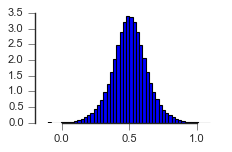

In [9]:
# Is there clipping
cs = hstack(data.contrast_probe)
sum((cs>1) | (cs<0.0))/float(len(cs))
figure(figsize=(3, 2))
_= hist(cs, linspace(-0.1, 1.1, 51), normed=True)
xticks([-0., 0.5, 1.])
sns.despine(offset=0, trim=True)
tight_layout()

__Fig S1.__ Is there any clipping of contrast values? Does not look like it. The vas majority of contrast values s within [0, 1]

#### Fix a few glitches in behavior: 
S3 confused the key ordering for high and low confidence 2nd grating in the first two sessions (20151207, 20151208). When S3 came in for the 3rd session I tested what keys S3 would press for the two options to confirm that S3 indeed confused the two keys. As predicted from the data S3 pressed the wrong keys. Upon explaining the key mapping S3 realized the mistake and confirmed that the wrong keys were used. I feel therefore confident to simply change the response here.
S11 confused key ordering during the training session (2016022). But S10 confused keys for the 1st grating

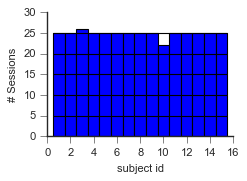

In [10]:
figure(figsize=(3, 2))
for s, sub in data.groupby('snum'):
    bar(s-0.5, len(unique(sub.session)), 1)
plot([0.5, 15.5], [25, 25], 'k')
plot([0.5, 15.5], [5, 5], 'k')
plot([0.5, 15.5], [10, 10], 'k')
plot([0.5, 15.5], [15, 15], 'k')
plot([0.5, 15.5], [20, 20], 'k')
sns.despine()
xlabel('subject id')
ylabel('# Sessions')

__ Fig S2. How many blocks are available per subject?__ Should be 25. Subject 10 is missing a few blocks because of a recording problem. Due to errors caused by the eye-tracker the data was not safed as .mat files, this was only detected after a few sessions. The cause of the error was some matlab interaction with other experiments (updated PTB or updated matlab). I'm not sure if this behavioral data can be recovered. 

Data Analysis
=======

Start by plotting confidence kernels with and without removing the mean of a trial.

In [11]:
# Compute kernel data frame
def get_pk(data, contrast_mean=0.5):
    '''
    Converts data to a data frame that is long form for different contrast probes.
    I.e. indexed by trial, time and whether contrast was for chosen or non-chosen option.
            
    ''' 
    dr1 = data.query('response==1')
    dr2 = data.query('response==-1')
    
    # Subtract QUEST mean from trials. 
    con_select2nd = vstack(dr1.contrast_probe) - contrast_mean - (dr1.cbm * dr1.side)[:, newaxis] 
    con_select1st = vstack(dr2.contrast_probe) - contrast_mean - (dr2.cbm * dr2.side)[:, newaxis]
        
    sel = vstack((con_select2nd, 0*con_select1st))
    nsel = vstack((con_select1st, 0*con_select2nd))

    
    sel = pd.DataFrame(sel)
    sel.index.name='trial'
    sel.columns.name='time'
    sel =  sel.unstack().reset_index()
    sel['optidx'] = 1
    sel = sel.set_index(['time', 'optidx', 'trial'])
    
    nsel = pd.DataFrame(nsel)
    nsel.index.name='trial'
    nsel.columns.name='time'
    nsel = nsel.unstack().reset_index()
    nsel['optidx'] = 0
    nsel = nsel.set_index(['time', 'optidx', 'trial'])
    df = pd.concat((sel, nsel))
    df.rename(columns={0:'contrast'}, inplace=True)
    return df

In [12]:
def get_pk_kernel(data, contrast_mean=0.5):
    kernel = (data.groupby(['snum'])
         .apply(lambda x: get_pk(x, contrast_mean=contrast_mean))
         .groupby(level=['snum', 'time', 'optidx']).mean()
         .reset_index())

    kernel_diff = (data.groupby(['snum'])
         .apply(lambda x: get_pk(x, contrast_mean=contrast_mean))
         .groupby(level=['snum', 'time'])
              .apply(lambda x: x.query('optidx==1').mean() + x.query('optidx==0').mean())
         .reset_index())

    kernel_diff['optidx'] = 3
    kernel = pd.concat((kernel, kernel_diff))
    return kernel

In [13]:
def plot_kernel(kernel, colors, legend=True, trim=True):
    g = sns.tsplot(time='time', unit='snum', value='contrast', condition='Kernel', 
               data=kernel, ci=95, color=colors, legend=legend)
    plot([0, 9], [0, 0], lw=1, color='k', alpha=0.5)
    yticks([-0.1, 0, 0.1])
    xlim([-0.5, 9.25])
    xlabel('Sample #')
    sns.despine(trim=True, ax=gca())
    return g
  

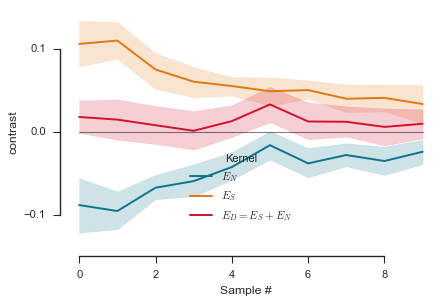

In [125]:
kernels = get_pk_kernel(dz, contrast_mean=0.)
condition = kernels.optidx.astype('category')
condition = condition.cat.rename_categories([r'$E_N$', r'$E_S$', r'$E_D = E_S + E_N$'])
kernels['Kernel'] = condition
palette = {r'$E_N$':color_palette['Secondary2'][0], 
           r'$E_S$':color_palette['Secondary1'][0], 
           r'$E_D = E_S + E_N$':color_palette['Primary'][0]}
g = plot_kernel(kernels, palette)
g.get_legend().set_bbox_to_anchor((.65, .45))

#subplot(2, 2, 2)
kernel = (dz.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, contrast_mean=0))
     .groupby(level=['confidence', 'optidx', 'snum', 'time']).mean()
     .reset_index())
palette = {r'$E_{N}^{High}$': color_palette['Secondary2'][0],
           r'$E_{N}^{Low}$': color_palette['Secondary2'][1], 
           r'$E_{S}^{Low}$': color_palette['Secondary1'][1], 
           r'$E_{S}^{High}$': color_palette['Secondary1'][0]}
condition = (kernel.confidence*(kernel.optidx-0.5)).astype('category')

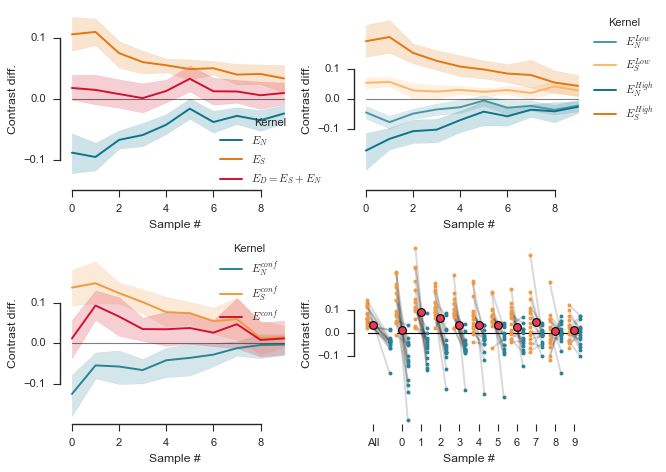

In [126]:
figure(figsize=(7.5, 6))    
subplot(2, 2, 1)

kernels_choice = get_pk_kernel(dz, contrast_mean=0.0)
condition = kernels_choice.optidx.astype('category')
condition = condition.cat.rename_categories([r'$E_N$', r'$E_S$', r'$E_D = E_S + E_N$'])
kernels_choice['Kernel'] = condition
palette = {r'$E_N$':color_palette['Secondary2'][0], 
           r'$E_S$':color_palette['Secondary1'][0], 
           r'$E_D = E_S + E_N$':color_palette['Primary'][0]}
g = plot_kernel(kernels_choice, palette)
g.get_legend().set_bbox_to_anchor((.65, .45))
ylabel('Contrast diff.')

subplot(2, 2, 2)
kernel = (dz.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, contrast_mean=0.0))
     .groupby(level=['confidence', 'optidx', 'snum', 'time']).mean()
     .reset_index())

palette = {r'$E_{N}^{High}$': color_palette['Secondary2'][0],
           r'$E_{N}^{Low}$': color_palette['Secondary2'][1], 
           r'$E_{S}^{Low}$': color_palette['Secondary1'][1], 
           r'$E_{S}^{High}$': color_palette['Secondary1'][0]}

condition = (kernel.confidence*(kernel.optidx-0.5)).astype('category')
condition = condition.cat.rename_categories([r'$E_{N}^{High}$', 
                                             r'$E_{N}^{Low}$', 
                                             r'$E_{S}^{Low}$', 
                                             r'$E_{S}^{High}$'])
kernel['Kernel'] = condition
g = plot_kernel(kernel, palette)
g.get_legend().set_bbox_to_anchor((1., 1))
ylabel('Contrast diff.')

subplot(2, 2, 3)
kernel = (dz.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, contrast_mean=0.))
     .groupby(level=['optidx', 'snum', 'time'])
          .apply(lambda x: x.query('confidence==2').mean()-x.query('confidence==1').mean())
     .reset_index())

df = lambda x: x.query('optidx==1').mean()+x.query('optidx==0').mean()

kernel_diff = (kernel.set_index(['snum', 'time', 'optidx'])
                     .groupby(level=['snum', 'time']).apply(df)).reset_index()
kernel_diff['optidx'] = 3
kd = pd.concat((kernel, kernel_diff))

kd['Kernel'] = (kd.optidx.astype('category', ordered=True)
                        .cat.rename_categories([r'$E_{N}^{conf}$', 
                                            r'$E_{S}^{conf}$', 
                                            r'$E^{conf}$']))

kd_diff = kd.copy()
palette = {r'$E_{N}^{conf}$':color_palette['Secondary2'][2], 
           r'$E_{S}^{conf}$':color_palette['Secondary1'][2],
           r'$E^{conf}$':color_palette['Primary'][0]}
g = plot_kernel(kd, colors=palette)

g.get_legend().set_bbox_to_anchor((.65, .5))

ylabel('Contrast diff.')

subplot(2, 2, 4)
m = kernel.groupby(['snum', 'optidx']).mean()
o0, o1 = m.loc[(slice(None), 0), 'contrast'], m.loc[(slice(None), 1), 'contrast'] 
d = o0.values+o1.values
for e, s in zip(o0, o1):
    plot([-.35-1.5, .35-1], [s,e], 'k-', alpha=.15, zorder=100)
    plot([-.35-1.5], [s], '.', color=color_palette['Secondary1'][2], alpha=1, zorder=100)
    plot([.35-1], [e], '.', color=color_palette['Secondary2'][2], alpha=1, zorder=100)

plot([-1.5], [mean(o1)+mean(o0)], 'o', color=color_palette['Primary'][2], lw=5, mec='k', mew=1, alpha=1, zorder=100)
plot([-1.75, -1.25], [0, 0], color='k', lw=1)
yticks([-.1, 0, .1])


for (s, t), kd in kernel.groupby(['snum', 'time']):
    kd = kd.set_index('optidx')
    o0, o1 = kd.loc[0, 'contrast'], kd.loc[1, 'contrast']     
    plot([t-.3, t+.3], [o1, o0], 'k-', alpha=0.15)
    plot([t-.3], [o1], '.', color=color_palette['Secondary1'][2], alpha=1, zorder=100)
    plot([t+.3], [o0], '.', color=color_palette['Secondary2'][2], alpha=1, zorder=100)
    
for t, kd in kernel.groupby(['time']):
    kd = kd.set_index('optidx')
    o0, o1 = kd.loc[0, 'contrast'], kd.loc[1, 'contrast']     
    plot([t], [mean(o1)+mean(o0)], 'o', color=color_palette['Primary'][2], lw=5, mec='k', mew=1,alpha=1, zorder=100)
    
plot([-.25, 9.25], [0, 0], color='k', lw=1)

xlim([-2.5, 9.5])
ylim(-0.4, .4)
_=xticks([-1.5] + range(0, 10), ['All'] + range(10))
xlabel('Sample #')
ylabel('Contrast diff.')
sns.despine(trim=True)
sns.despine(bottom=True, ax=gca())

tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/fig1_kernel_overview.pdf', bbox_inches='tight')

#### Evaluate Choice assymetry with ANOVA and t-test.

In [118]:
import rpy2.robjects as robjects

def ranova_rm(dv, factors, data, time_continuos=False):
    kd = data.copy()
    kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
    fstring = ''
    for factor in factors:
        fstring += factor +','
        if time_continuos and factor=='time':
            continue
        kd.loc[:, factor] = 'F' + kd[factor].astype(str)
    fstring = fstring[:-1]
    kd.to_csv('/Users/nwilming/kernels2.csv')
    R_cmd = '''
    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, %s, wid=snum, within=.(%s))
    '''%(dv, fstring)
    print R_cmd
    print robjects.r(R_cmd)

In [128]:
from scipy.stats import ttest_1samp
# Do a repeated measures ANOVA in R using ezANOVA
df_choice = kernels_choice.query('optidx<3')
idx = df_choice.optidx.values==1
df_choice.loc[idx, 'contrast'] *= -1
ranova_rm('contrast', ['time', 'optidx'], df_choice)

print 'One sample t-test to compare group means:'
print ttest_1samp(kernels_choice.query('optidx==3').groupby('snum').mean().contrast.values, 0)
print 



    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, contrast, wid=snum, within=.(time,optidx))
    
$ANOVA
       Effect DFn DFd          F            p p<.05        ges
2        time   9 126 14.5838378 5.699805e-16     * 0.30698511
3      optidx   1  14  4.2898427 5.730111e-02       0.02837794
4 time:optidx   9 126  0.7479425 6.643854e-01       0.01115087

$`Mauchly's Test for Sphericity`
       Effect            W            p p<.05
2        time 0.0002524323 0.0001541966     *
4 time:optidx 0.0489876105 0.9248756938      

$`Sphericity Corrections`
       Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF] p[HF]<.05
2        time 0.3100774 2.539375e-06         * 0.3951128 1.585065e-07         *
4 time:optidx 0.6452567 6.086729e-01           1.1542763 6.643854e-01          


One sample t-test to compare group means:
Ttest_1sampResult(sta

### Evaluate Confidence kernel assymetry

In [129]:
kd = kd_diff.query('optidx<=2')
idx = kd.optidx.values==1
kd.loc[idx, 'contrast'] *= -1
# Do a repeated measures ANOVA in R using ezANOVA
ranova_rm('contrast', ['time', 'optidx'], kd)

print 'One sample t-test to compare group means:'
print ttest_1samp(kd_diff.query('optidx==3').groupby('snum').mean().contrast.values, 0)
print 


    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, contrast, wid=snum, within=.(time,optidx))
    
$ANOVA
       Effect DFn DFd         F            p p<.05        ges
2        time   9 126  8.889494 2.720107e-10     * 0.21503811
3      optidx   1  14 11.319206 4.629389e-03     * 0.06020267
4 time:optidx   9 126  1.571989 1.305576e-01       0.02907512

$`Mauchly's Test for Sphericity`
       Effect            W           p p<.05
2        time 0.0009437312 0.004590585     *
4 time:optidx 0.0064335647 0.182747582      

$`Sphericity Corrections`
       Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF] p[HF]<.05
2        time 0.3623262 6.278576e-05         * 0.4853933 5.603059e-06         *
4 time:optidx 0.5590940 1.788628e-01           0.9103532 1.390013e-01          


One sample t-test to compare group means:
Ttest_1sampResult(statistic=

### Evaluate Difference between kernels

In [130]:
dchoice = kernels_choice.query('optidx==3')
dchoice.loc[:, 'type'] = 0
dchoice = dchoice.loc[:, ['contrast', 'snum', 'time', 'type']]
dconf = kd_diff.query('optidx==3')
dconf.loc[:, 'type'] = 1
dconf = dconf.loc[:, ['contrast', 'snum', 'time', 'type']]
kd = pd.concat([dconf, dchoice])

ranova_rm('contrast', ['time', 'type'], kd)

ttest_1samp(diff(kd.groupby(['snum', 'type']).mean().unstack()['contrast'].values, 1), 0)





    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, contrast, wid=snum, within=.(time,type))
    
$ANOVA
     Effect DFn DFd        F         p p<.05        ges
2      time   9 126 1.368679 0.2091604       0.03848100
3      type   1  14 2.803328 0.1162535       0.03006363
4 time:type   9 126 1.490301 0.1583851       0.03547204

$`Mauchly's Test for Sphericity`
     Effect           W          p p<.05
2      time 0.008392323 0.26155426      
4 time:type 0.003083219 0.05500016      

$`Sphericity Corrections`
     Effect       GGe     p[GG] p[GG]<.05       HFe     p[HF] p[HF]<.05
2      time 0.5983656 0.2427903           1.0160833 0.2091604          
4 time:type 0.5670298 0.2027296           0.9310412 0.1646191          




Ttest_1sampResult(statistic=array([ 1.67431432]), pvalue=array([ 0.11625345]))

### Compute regressions for t=1-9

In [131]:
from scipy.stats import linregress
dconf = kd_diff.query('optidx==3')
def foo(x):
    t = x.time.values
    xvals = x.contrast.values
    s, i, r, p, se = linregress(t, y=xvals)
    return pd.DataFrame({'slope':s, 'offset':i, 'corr':r, 'p':p}, index=[1])

ps = dconf.query('time>0').groupby('snum').apply(foo)

print 'Slopes: ', ps.slope.mean(), ttest_1samp(ps.slope.values, 0)
print 'Offset: ', ps.offset.mean(), ttest_1samp(ps.offset.values, 0)
print 'R**2: ', (ps['corr']**2).mean()

Slopes:  -0.00805131965283 Ttest_1sampResult(statistic=-2.608269076413074, pvalue=0.020642342778728402)
Offset:  0.0799001212533 Ttest_1sampResult(statistic=5.1249051308756375, pvalue=0.00015445186327876884)
R**2:  0.203355319857


## Kernels w.r.t noise variance

In [132]:
kernels_choice_ns = dz.groupby('noise_sigma').apply(lambda x: get_pk_kernel(x, contrast_mean=0.0))
condition = kernels_choice_ns.optidx.astype('category')
condition = condition.cat.rename_categories([r'$E_N$', r'$E_S$', r'$E_D = E_S + E_N$'])
kernels_choice_ns['Kernel'] = condition
palette_choice = {r'$E_N$':color_palette['Secondary2'][0], 
           r'$E_S$':color_palette['Secondary1'][0], 
           r'$E_D = E_S + E_N$':color_palette['Primary'][0]}

kernel = (dz.groupby(['confidence', 'snum', 'noise_sigma'])
     .apply(lambda x: get_pk(x, contrast_mean=0))
     .groupby(level=['optidx', 'snum', 'time', 'noise_sigma'])
          .apply(lambda x: x.query('confidence==2').mean()-x.query('confidence==1').mean())
     .reset_index())

df = lambda x: x.query('optidx==1').mean()+x.query('optidx==0').mean()

kernel_diff = (kernel.set_index(['snum', 'time', 'optidx', 'noise_sigma'])
                     .groupby(level=['noise_sigma', 'snum', 'time']).apply(df)).reset_index()
kernel_diff['optidx'] = 3
kd_ns = pd.concat((kernel, kernel_diff))

kd_ns['Kernel'] = (kd_ns.optidx.astype('category', ordered=True)
                    .cat.rename_categories([r'$E_{N}^{conf}$', 
                                            r'$E_{S}^{conf}$', 
                                            r'$E^{conf}$']))

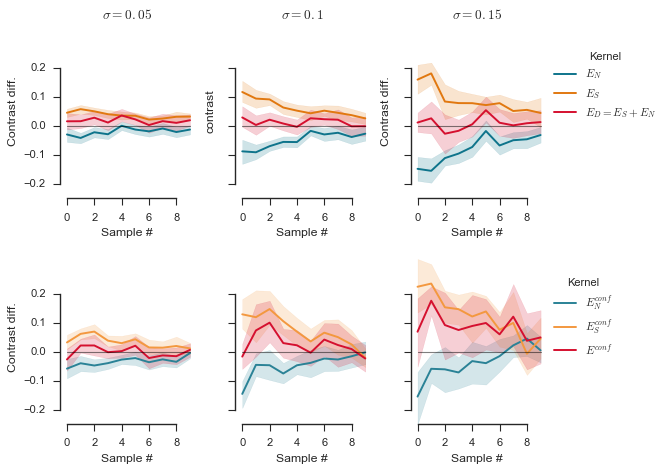

In [133]:
palette = {r'$E_{N}^{conf}$':color_palette['Secondary2'][2], 
           r'$E_{S}^{conf}$':color_palette['Secondary1'][2],
           r'$E^{conf}$':color_palette['Primary'][0]}

mapping = {0:r'$\sigma = 0.05$', 1:r'$\sigma = 0.1$', 2:r'$\sigma = 0.15$',}
figure(figsize=(7, 6))
for i, (c, k) in enumerate(kernels_choice_ns.groupby(level='noise_sigma')):
    subplot(2, 3, i + 1)
    g = plot_kernel(k, palette_choice)
    #g.get_legend().set_bbox_to_anchor((.65, .45))
    if i<2:
        legend('')
    if i==0:
        ylabel('Contrast diff.')
    ylim([-.25, .35])
    yticks([-.2, -.1, 0, .1, .2])
    if i>0:
        yticks([-.2, -.1, 0, .1, .2], [])
    title(mapping[i])
    
g.get_legend().set_bbox_to_anchor((1, .9))
g.set_ylabel('Contrast diff.')
        
for i, (c, k) in enumerate(kd_ns.groupby('noise_sigma')):
    subplot(2, 3, i + 1 + 3)
    g = plot_kernel(k, palette, legend=i==2, trim=False)
    yticks([-.2, 0, .2])
    if i>0:
        ylabel('')
        yticks([-.2, 0, .2], ['', '', ''])
    if i==0:
        ylabel('Contrast diff.')
    ylim([-.25, .35])
    yticks([-.2, -.1, 0, .1, .2])
    if i>0:
        yticks([-.2, -.1, 0, .1, .2], [])
    sns.despine(trim=True)
g.get_legend().set_bbox_to_anchor((1, .9))
tight_layout()

#g.set(ylim=(-0.055, 0.055))
savefig('/Users/nwilming/u/conf_analysis/plots/kernels_by_variance.pdf', bbox_inches='tight')

In [134]:
dchoicens = kernels_choice_ns.query('optidx==3').reset_index()
dchoicens.loc[:, 'type'] = 0
dchoicens = dchoicens.loc[:, ['contrast', 'snum', 'time', 'type', 'noise_sigma']]



dconfns = kd_ns.query('optidx==3')
dconfns.loc[:, 'type'] = 1
dconfns = dconfns.loc[:, ['contrast', 'snum', 'time', 'type', 'noise_sigma']]
kdns = pd.concat([dconfns.reset_index(), dchoicens.reset_index()])

ranova_rm('contrast', ['type', 'noise_sigma'], kdns, time_continuos=False)



    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, contrast, wid=snum, within=.(type,noise_sigma))
    
$ANOVA
            Effect DFn DFd         F            p p<.05        ges
2             type   1  14  3.341920 0.0889201359       0.05566462
3      noise_sigma   2  28  3.971129 0.0303205811     * 0.10278811
4 type:noise_sigma   2  28 11.152512 0.0002739387     * 0.14448276

$`Mauchly's Test for Sphericity`
            Effect         W          p p<.05
3      noise_sigma 0.6372757 0.05347216      
4 type:noise_sigma 0.8104150 0.25503430      

$`Sphericity Corrections`
            Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF]
3      noise_sigma 0.7338241 0.0459671689         * 0.7985223 0.0415365908
4 type:noise_sigma 0.8406293 0.0006800428         * 0.9424209 0.0003802008
  p[HF]<.05
3         *
4         *




In [135]:
for ns, kd in kdns.groupby('noise_sigma'):
    print ''
    print 'RM ANOVA for noise_sigma=', ns
    print '*'*40



RM ANOVA for noise_sigma= 0.05
****************************************

    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, contrast, wid=snum, within=.(time,type))
    
$ANOVA
     Effect DFn DFd        F          p p<.05        ges
2      time   9 126 2.072606 0.03671614     * 0.04611106
3      type   1  14 2.596222 0.12942715       0.03060159
4 time:type   9 126 1.161036 0.32569797       0.01790781

$`Mauchly's Test for Sphericity`
     Effect           W          p p<.05
2      time 0.002622195 0.04065014     *
4 time:type 0.004838345 0.11885933      

$`Sphericity Corrections`
     Effect       GGe      p[GG] p[GG]<.05       HFe      p[HF] p[HF]<.05
2      time 0.6159183 0.07105353           1.0661976 0.03671614         *
4 time:type 0.5283511 0.33740577           0.8332264 0.33068727          



RM ANOVA for noise_sigma= 0.1
******************

In [ ]:
from scipy.stats import ttest_1samp
# Do a repeated measures ANOVA in R using ezANOVA

kd = kernel.query('time>=0')
kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
kd.loc[:, 'time'] = 'T' + kd.time.astype(str)
kd.loc[:, 'optidx'] = 'C' + kd.optidx.astype(str)
kd.loc[:, 'noise_sigma'] = 'N' + kd.noise_sigma.astype(str)

kd.to_csv('/Users/nwilming/kernels2.csv')

print 'One sample t-test to compare group means:'
print ttest_1samp(kernel_diff.groupby('snum').mean().contrast.values, 0)
print 

print 'RM ANOVA in R:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, contrast, wid=snum, within=.(optidx, noise_sigma))
'''
print robjects.r(R_cmd)



Kernels binned by empirical mean contrast
=======

In [14]:
def cutme(stdc, n=7):
    low, high = percentile(stdc, [0, 95])
    std_bins = linspace(low, high, n+1)
    labels = [x+(x-y)/2. for x,y in zip(std_bins[:-1], std_bins[1:])]
    return pd.cut(stdc, std_bins, labels=arange(n))

cuts = dz.groupby('snum').stdc.apply(cutme)
dz.loc[:, 'stdcut'] = cuts

In [15]:
kernels_choice_ns = dz.groupby(['snum', 'stdcut']).apply(lambda x: get_pk_kernel(x, contrast_mean=0.0))
condition = kernels_choice_ns.optidx.astype('category')
condition = condition.cat.rename_categories([r'$E_N$', r'$E_S$', r'$E_D = E_S + E_N$'])
kernels_choice_ns['Kernel'] = condition
palette_choice = {r'$E_N$':color_palette['Secondary2'][0], 
           r'$E_S$':color_palette['Secondary1'][0], 
           r'$E_D = E_S + E_N$':color_palette['Primary'][0]}

In [16]:
del kernels_choice_ns['snum']
kernels_choice_ns.head()

contrast  optidx  time Kernel
snum stdcut                                 
1    0      0  0.028343       0     0  $E_N$
            1  0.050949       1     0  $E_S$
            2  0.028142       0     1  $E_N$
            3 -0.010798       1     1  $E_S$
            4  0.037064       0     2  $E_N$

In [17]:
kernel = (dz.groupby(['confidence', 'snum', 'stdcut'])
     .apply(lambda x: get_pk(x, contrast_mean=0))
     .groupby(level=['optidx', 'snum', 'time', 'stdcut'])
          .apply(lambda x: x.query('confidence==2').mean()-x.query('confidence==1').mean())
     .reset_index())

df = lambda x: x.query('optidx==1').mean()+x.query('optidx==0').mean()
kernel_diff = (kernel.set_index(['snum', 'time', 'optidx', 'stdcut'])
                     .groupby(level=['stdcut', 'snum', 'time']).apply(df)).reset_index()
kernel_diff['optidx'] = 3
kd_ns = pd.concat((kernel, kernel_diff))

kd_ns['Kernel'] = (kd_ns.optidx.astype('category', ordered=True)
                    .cat.rename_categories([r'$E_{N}^{conf}$', 
                                            r'$E_{S}^{conf}$', 
                                            r'$E^{conf}$']))

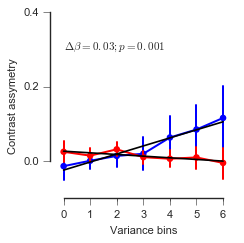

In [185]:
from scipy.stats import linregress, ttest_1samp, ttest_rel
figure(figsize=(3,3))

g = sns.pointplot(x='stdcut', y='contrast', units='snum', 
        data=kd_ns.query('optidx==3  &time>=0 & time<15'), 
        ci=95, ax=gca())

g2 = sns.pointplot(x='stdcut', y='contrast', units='snum',
                  data=kernels_choice_ns.reset_index().query('optidx==3  &time>=0 & time<15'),
                  ci=95, color='r', ax=gca())

p = pd.pivot_table(index='stdcut', columns='snum', values='contrast', 
                   data=kd_ns.query('optidx==3  &time>=0 & time<15'), )
pchoice = pd.pivot_table(index='stdcut', columns='snum', values='contrast', 
                   data=kernels_choice_ns.reset_index().query('optidx==3  & time>=0 & time<15'), )

bs_conf, offs_conf = [], []
bs_choice, offs_choice = [], []
for snum, row in p.T.iterrows():
    b, off, _, _, _ = linregress(arange(len(row)), row)
    bs_conf.append(b)
    offs_conf.append(off)
for snum, row in pchoice.T.iterrows():
    b, off, _, _, _ = linregress(arange(len(row)), row)
    bs_choice.append(b)
    offs_choice.append(off)
xv = arange(len(row))
plot(xv, xv*mean(bs_conf)+mean(offs_conf), 'k', lw=1.5)
plot(xv, xv*mean(bs_choice)+mean(offs_choice), 'k', lw=1.5)

tval, pval = ttest_rel(bs_conf, bs_choice)
xlabel('Variance bins')
ylabel('Contrast assymetry')
g.set_yticks([0, 0.2, 0.4])
g.set_xticks([0, 2, 4, 6], [0, 2, 4, 6])

#plt.locator_params(nbins=5)
sns.despine(trim=5)
text(0., .3, r'$\Delta\beta=%1.2f; p=%0.3f$'%(around(mean(bs_conf)-mean(bs_choice), 2), around(pval, 3)))
savefig('/Users/nwilming/u/conf_analysis/plots/confidence_assymetry_binned.pdf')

[0.11134495085762958, 0.31490039300669953, 0.26751509779699423, 0.68871758636208225, 0.036098842637087514, 0.049916099471613913, 0.0010011741721621171]


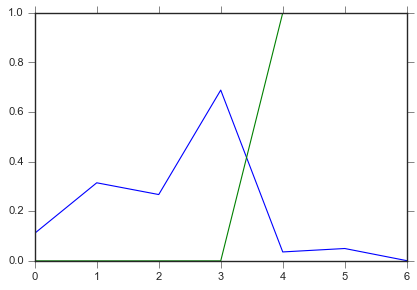

In [201]:
conf_assym = kd_ns.query('optidx==3  &time>=0 & time<10')
choice_assym = kernels_choice_ns.reset_index().query('optidx==3  &time>=0 & time<10')

conf_assym = pd.pivot_table(index='stdcut', values='contrast', columns='snum', data=conf_assym)
choice_assym = pd.pivot_table(index='stdcut', values='contrast', columns='snum', data=choice_assym)

ps = []
for (t, tconf), (tt, tchoice) in zip(conf_assym.iterrows(), choice_assym.iterrows()):
    ps.append(ttest_rel(tconf.values, tchoice.values)[1])

plot(ps)
print ps
plot(array(ps)<(0.05))

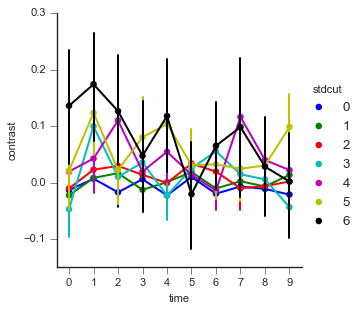

In [49]:
sns.factorplot(x='time', unit='snum', y='contrast', hue='stdcut', data=kd_ns)

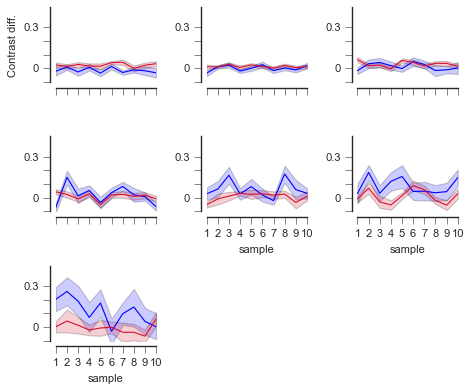

In [100]:
palette = {r'$E_{N}^{conf}$':color_palette['Secondary2'][2], 
           r'$E_{S}^{conf}$':color_palette['Secondary1'][2],
           r'$E^{conf}$':color_palette['Primary'][0]}

figure(figsize=(6, 5))
for i, ((c, k), (cc, kk)) in enumerate(zip(
        kd_ns.query('optidx==3').groupby('stdcut'),
        kernels_choice_ns.reset_index().query('optidx==3').groupby('stdcut'))):
    subplot(3, 3, i+1)
    g = sns.tsplot(time='time', unit='snum', value='contrast', 
                data=k, ci=68)

    g = sns.tsplot(time='time', unit='snum', value='contrast', 
            data=kk, ci=68, color=palette[r'$E^{conf}$'], ax=gca())
    #g = plot_kernel(k, palette, legend=False, trim=True)
    yticks([-.2, 0, .2])
    if i>0:
        ylabel('')
        yticks([-.2, 0, .2], ['', '', ''])
    if i==0:
        ylabel('Contrast diff.')
    ylim([-.1, .45])
    yticks([-.1, 0, .1, .2, .3], ['', 0, '', '', 0.3])
    if i>3:
        xlabel('sample')
        xticks(arange(10), arange(10)+1)
    else:
        xlabel('')
        xticks(arange(10), ['']*10)
    sns.despine(offset=5)
    
ax = gca()
tight_layout()

savefig('/Users/nwilming/u/conf_analysis/plots/kernels_by_binned_sampled_std.svg')
savefig('/Users/nwilming/u/conf_analysis/plots/kernels_by_binned_sampled_std.pdf')


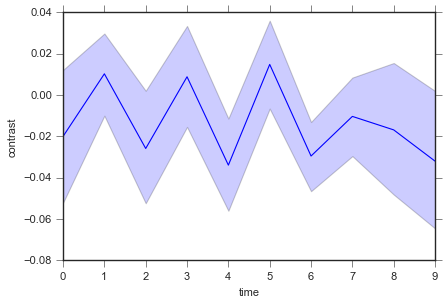

In [97]:
g = sns.tsplot(time='time', unit='snum', value='contrast', 
                data=k, ci=68)

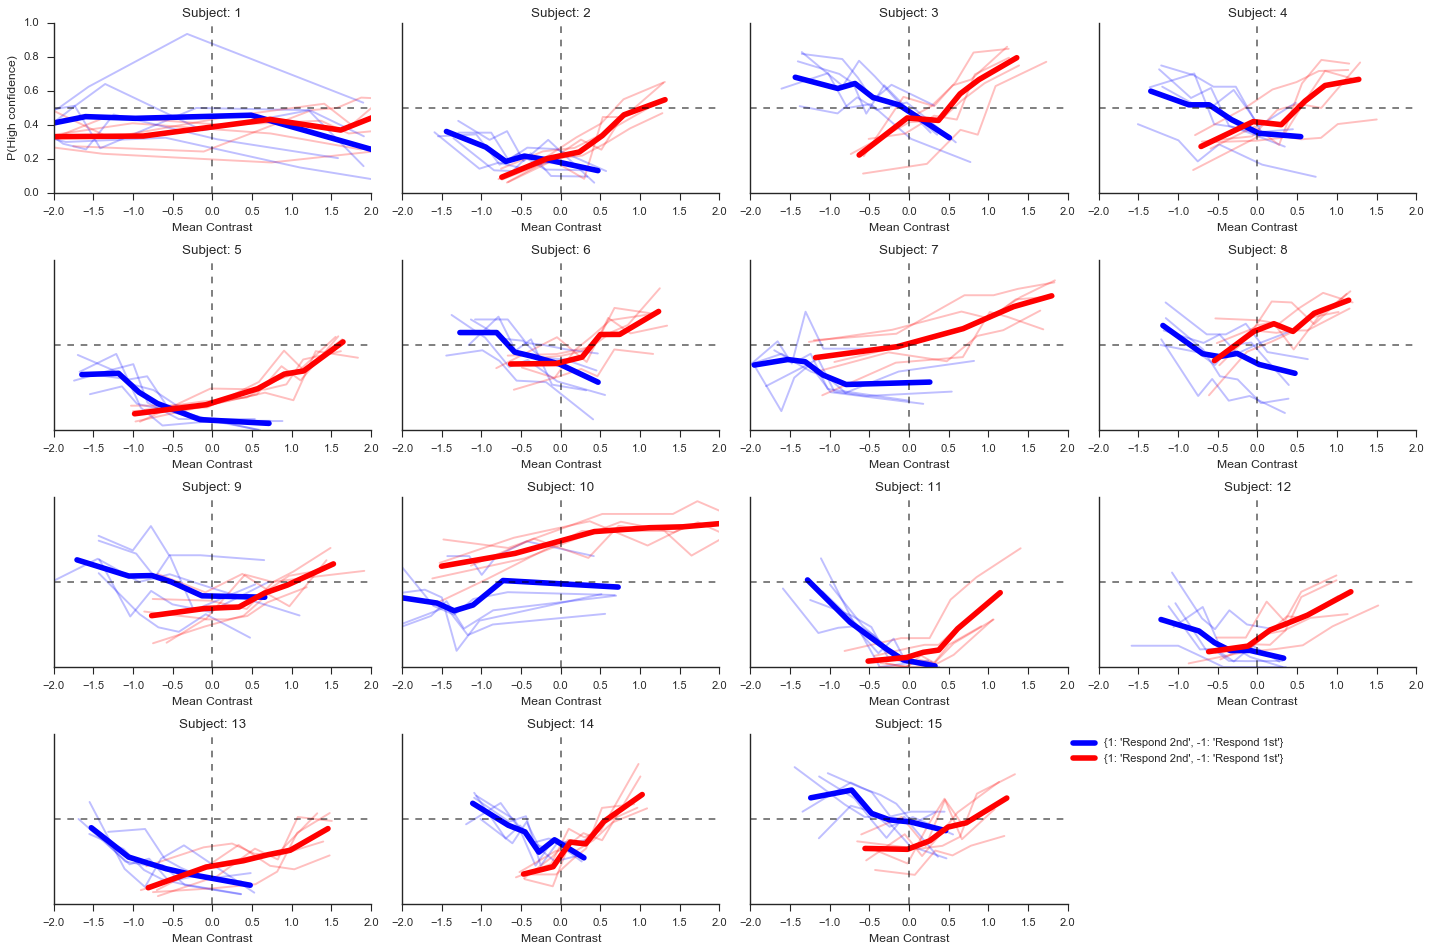

In [137]:
figure(figsize=(18, 12))
for c, sub in dz.groupby('snum'):
    subplot(4,4,c)
    cnt = 0
    for (block, response), s in sub.groupby(['day', 'response']):
        centers, frac = empirical.asfuncof(s.mc.values, s.confidence.values==2, bins=linspace(1,99, 7))
        plot(centers, frac, {-1:'b-', 1:'r-'}[response], alpha=0.25)
    for response, s in sub.groupby('response'):
        centers, frac = empirical.asfuncof(s.mc.values, s.confidence.values==2, bins=linspace(1,99, 7))
        plot(centers, frac, {-1:'b-', 1:'r-'}[response], alpha=1, lw=5, label={-1:'Respond 1st', 1:'Respond 2nd'})

    sns.despine()
    ylim([0, 1])
    xlim([-2, 2])
    if c>1:
        yticks([])
    xlabel('Mean Contrast')
    if c==1:
        ylabel('P(High confidence)')
    plot(xlim(), [0.5, 0.5], 'k--', alpha=0.5)  
    plot([0., 0.],ylim(), 'k--', alpha=0.5)  
    title('Subject: %i'%c)
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/confidence_vs_contrast.pdf')

Comparison to Sanders et al. Neuron 2016 paper
----------------------------------------------

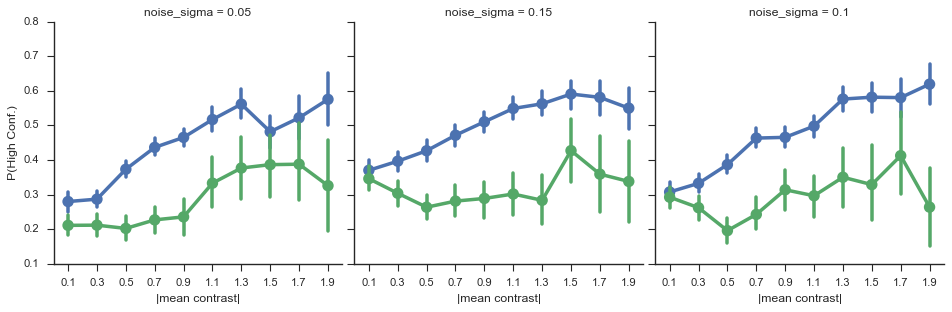

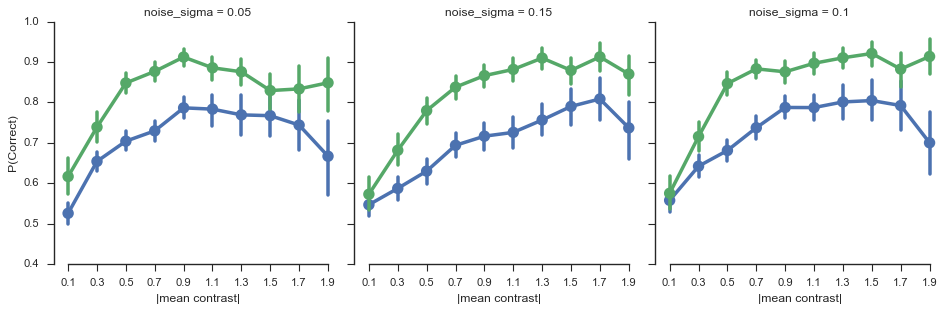

In [138]:
figure(figsize=(7, 3.5))
def histify(x, bins, field, name, labels=None):
    if labels is None:
        labels = around([(low + (high-low)/2.) for low, high in zip(bins[:-1], bins[1:])], 2)
    bins = pd.cut(x[field], bins, labels=labels)
    x[name] = bins
    return x

dz.loc[:, 'conf_0index'] = dz.confidence-1
dz.loc[:, 'absmc'] = abs(dz.mc)
absmcut = linspace(0, 2, 11)#linspace(0, 1.5, 9) #prctile(dz.query('snum>1').absmc, linspace(5, 95, 7))
mcut = linspace(-1.5, 1.5, 12) #prctile(dz.query('snum>1').absmc, linspace(5, 95, 7))

dz = histify(dz, mcut, 'mc', 'mccut')
dz = histify(dz, absmcut, 'absmc', 'abs(Contrast)')


g = sns.factorplot(x='abs(Contrast)', y='conf_0index', unit='snum', 
               data=dz, hue='correct', col='noise_sigma', legend=False)

g.set_xlabels('|mean contrast|')
g.set_ylabels('P(High Conf.)')
#l = gca().get_legend()
#legend(l.legendHandles, ['Correct', 'Error'], loc=2)
savefig('/Users/nwilming/u/conf_analysis/plots/sanders_comp1B.pdf', bbox_inches='tight')

g = sns.factorplot(x='abs(Contrast)', y='correct', unit='snum', 
               data=dz, hue='confidence', col='noise_sigma', legend=False)
g.set_xlabels('|mean contrast|')
g.set_ylabels('P(Correct)')
#l = gca().get_legend()
#legend(l.legendHandles, ['Low confidence', 'High confidence'], loc=4)
sns.despine(trim=True)
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/sanders_comp1C.pdf', bbox_inches='tight')

__ Fig 3. Confidence as a function of mean (sample) contrast in a trial.__ The y-axis shows the proportion of high confidence judgements. X-axis shows the mean contrast of a trial. Blue lines decisions for the 1st grating, red lines for the 2nd grating. Thick lines are pooled across all sessions, thin lines are individual sessions.  

Confidence and Accuracy vs. Variance
----------------------------------

The next upcoming plots are meant as a point of comparison with the Zylberberg et al. variance misperception paper.

   1. Accuracy and fraction of high confidence ratings vs. Contrast and Variance. This should map to figure 1b and h. I guess the crucial comparison is to evaluate whether confidence a contrast 0.5 scales with variance. Also check if performance at contrast=0.5 is chance.
 
    
The next plot shows the fraction of high confidence reports as a function of contrast in a trial.

In [165]:
surface_bins = [linspace(0, 3.,31), linspace(-2.25, 2.25,26)]

def conf_surface(data, bins, cmap=None, vmin=None, vmax=None, mincnt=1, field='confidence'):
    tmp = data.dropna(subset=['mc', 'stdc', field])
    a,b,c = histogram2d(tmp.stdc.values, tmp.mc.values, bins=bins)
    idlow = a<mincnt
    a2,b,c = histogram2d(tmp.stdc.values, tmp.mc.values, bins=bins, 
                         weights=tmp[field].values-1)
    m = a2.astype(float)/a

    idnan = isnan(m) | idlow
    m[isnan(m) | idlow] = nan
    m.reshape(a2.shape)
    C, B = meshgrid(c, b)

    pcol = pcolormesh(C, B, np.ma.masked_invalid(m), vmin=vmin, vmax=vmax, cmap=cmap, 
                      linewidth=0, rasterized=True)#, interpolation='none')
    print pcol.get_clim()
    pcol.set_edgecolor('face')
    ylim(0, 3)
    xlim(-4, 4)
    sns.despine()
    
    
def confidence_borders(nd, plot=True, field='conf0_index', bins=surface_bins):
    sc, mc = meshgrid(*bins)
    Z = 0*sc
    y, X = patsy.dmatrices('%s ~ abs(mc) + stdc'%field, data=nd.query('mc>0'))
    mdl_full = sm.formula.Logit(y, X).fit(maxiter=100, disp=0)
    sc, mc = meshgrid(*bins)
    inter, mcpa, stdcpa = mdl_full.params
    Z = (mc)*mcpa+stdcpa*sc+inter

    t = Z[(mc==0)&(sc==3)] 
    if plot:
        _=contour(mc, sc, Z, [0.5, 1, 2], colors='k', linestyles='solid')
    y, X = patsy.dmatrices('%s ~ abs(mc) + stdc'%field, data=nd.query('mc<0'))
    
    mdl_full = sm.formula.Logit(y, X).fit(maxiter=100, disp=0)
    
    inter, mcpb, stdcpb = mdl_full.params
    try:
        Z = (mc)*mcpb+stdcpb*sc+inter

        t = Z[(mc==0)&(sc==3)] 
        if plot:
            contour(mc, sc, Z, [-2, -1, -0.5], colors='gray', linestyles='solid')
    except Exception as E:
        print E
    return mcpa, -stdcpa, mcpb, -stdcpb



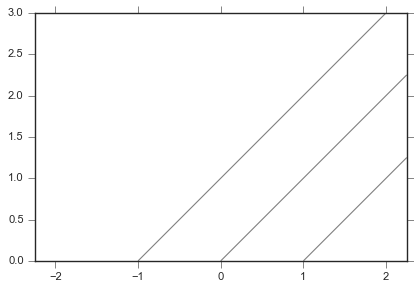

In [151]:
bins  = surface_bins
sc, mc = meshgrid(*bins)
mcpb = 1
stdcpb = -1
inter = 0
Z = (mc)*mcpb+stdcpb*sc+inter
contour(mc, sc, Z, [-1, 0, 1], colors='gray', linestyles='solid')

In [235]:
data['conf_0index'] = data.confidence-1
dz['conf_0index'] = dz.confidence-1

def pcut(x, bins, name):
    bins_left = prctile(x.mc[x.mc<=0.5], bins)
    bins_right = prctile(x.mc[x.mc>0.5], bins)
    bins = concatenate((bins_left, bins_right[1:]))
    labels = arange(len(bins)-1)
    bins = pd.cut(x.mc, bins, labels=labels-labels[-1]/2.)
    x[name] = bins
    return x


def qcut(x, bins, name):
    labels = around([(low + (high-low)/2.) for low, high in zip(bins[:-1], bins[1:])], 2)
    bins = pd.cut(x.mc, bins, labels=labels)
    x[name] = bins
    return x

def rvsv(data, bins, values, cut=pcut):
        return (data.groupby('snum')
                     .apply(lambda x: cut(x, bins, 'rankcon'))
                     .pivot_table(values=values, index='rankcon', columns='snum'))
        
def resp_vs_variance(data, bins, values='conf_0index', cut=pcut):
    r1 = rvsv(data, bins, values, cut)
    centers = array(r1.index.values)
    _ = plot(centers, nanmean(r1.values, 1), lw=2.5, alpha=1)
    
def cutme(stdc, n=4):
    low, high = percentile(stdc, [1, 99])
    std_bins = linspace(low, high, n+1)
    labels = [x+(x-y)/2. for x,y in zip(std_bins[:-1], std_bins[1:])]
    return pd.cut(stdc, std_bins, labels=arange(n))

cuts = dz.groupby('snum').stdc.apply(cutme)
dz.loc[:, 'stdcut3'] = cuts

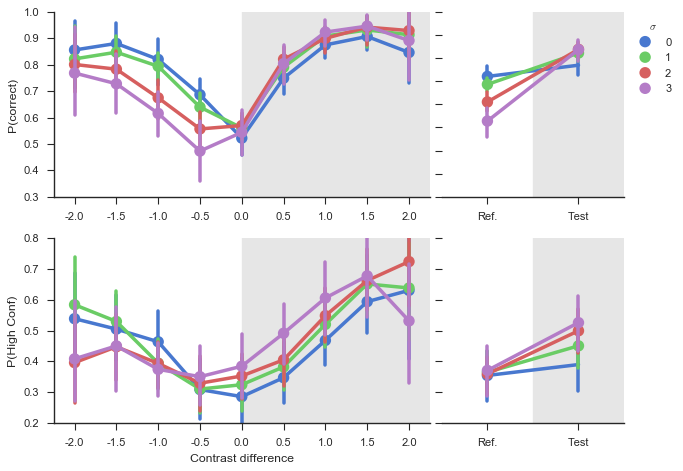

In [236]:
edges = arange(-2.25, 2.5, .5)
dlin = (dz.groupby(['snum', 'session_num', 'block_num'])
         .apply(lambda x: qcut(x, edges, 'lincon'))
         .groupby(['lincon', 'snum', 'stdcut3', 'session_num', 'block_num'])
         .mean()
         .reset_index())

#palette = {0: color_palette2['Primary'][0], 
#           1: color_palette2['Secondary1'][0],
#           2: color_palette2['Secondary2'][0],
#           3: 'r',
#           4: 'b'
#        }

palette = dict((i, color) for i, color in enumerate(sns.color_palette('muted', n_colors=len(unique(dz.stdcut3)))))

gs = matplotlib.gridspec.GridSpec(2, 3)
figure(figsize=(8, 6))
subplot(gs[0, :2])
sns.pointplot(x='lincon', y='correct', hue='stdcut3', units='snum', ci=95, data=dlin, palette=palette)
ylabel('P(correct)')
legend('')
xlabel('')
ylim([0.3, 1])
zpos = mean(xlim())
gca().add_patch(Rectangle((4., .0) , 4.5,1, color=(.9, .9, .9), zorder=-1))

#axvline(zpos, color='k', lw=1.5, zorder=-inf)


sns.despine(bottom=False, ax=gca())
subplot(gs[1, :2])
sns.pointplot(x='lincon', y='conf_0index', hue='stdcut3', units='snum', ci=95, data=dlin, palette=palette)
ylabel('P(High Conf)')
xlabel('Contrast difference')
legend('')
ylim([0.2, 0.8])

zpos = mean(xlim())
gca().add_patch(Rectangle((4., .0) , 4.5,1, color=(.9, .9, .9), zorder=-1))

#axvline(zpos, color='k', lw=1.5, zorder=-inf)
sns.despine(ax=gca())

dlin_sub = (dz.groupby(['snum', 'session_num', 'block_num'])
         .apply(lambda x: qcut(x, linspace(-3.5,3.5,3), 'lincon'))
         .groupby(['lincon', 'snum', 'stdcut3', 'session_num', 'block_num'])
         .mean()
         .reset_index())
dlin_sub.loc[:, r'$\sigma$'] = dlin.stdcut3

subplot(gs[0, 2])
g = sns.pointplot(x='lincon', y='correct', hue=r'$\sigma$', units='snum', ci=95, data=dlin_sub, palette=palette)
xticks(xticks()[0], ['Ref.', 'Test'])
ylim([0.3, 1])
yticks(yticks()[0], [])
ylabel('')
xlabel('')
gca().add_patch(Rectangle((.5, .0) , 1,1, color=(.9, .9, .9)))

sns.despine(left=True, ax=gca())

l = g.get_legend()
l.set_bbox_to_anchor((1, 1))


subplot(gs[1, 2])
sns.pointplot(x='lincon', y='conf_0index', hue='stdcut3', units='snum', ci=95, data=dlin_sub, palette=palette)
xlabel('')
legend('')
ylim([0.2, 0.8])
xticks(xticks()[0], ['Ref.', 'Test'])
yticks(yticks()[0], [])
ylabel('')
gca().add_patch(Rectangle((.5, .0) , 1,1, color=(.9, .9, .9)))

sns.despine(left=True, ax=gca())

#sns.despine(trim=True)
tight_layout()

savefig('/Users/nwilming/u/conf_analysis/plots/fig2_mean_confidence_accuracy_vs_contrast_binned.pdf', 
        bbox_inches='tight')

In [331]:
def foo():
    from scipy.stats import ttest_1samp
    # Do a repeated measures ANOVA in R using ezANOVA

    edges = arange(-1.75, 1.76, 0.5)
    print edges
    kd = (dz.loc[~isnan(dz.trial),:].groupby(['snum'])
             .apply(lambda x: qcut(x, edges, 'lincon'))
             .groupby(['lincon', 'snum', 'noise_sigma'])
             .mean()
             .reset_index())

    kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
    kd.loc[:, 'lincon'] = 'T' + kd.lincon.astype(str)
    kd.loc[:, 'noise_sigma'] = 'N' + kd.noise_sigma.astype(str)

    kd.to_csv('/Users/nwilming/kernels2.csv')

    print 'One sample t-test to compare group means:'
    print ttest_1samp(kernel_diff.groupby('snum').mean().contrast.values, 0)
    print 

    print 'RM ANOVA in R:'
    import rpy2.robjects as robjects
    R_cmd = '''
    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, %s, wid=snum, within=.(lincon, noise_sigma))
    '''

    print 'RM ANOVA for accuracy:'
    print robjects.r(R_cmd%'correct')
    print 

    print 'RM ANOVA for confidence'
    print robjects.r(R_cmd%'conf_0index')

foo()

[-1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75]
One sample t-test to compare group means:
Ttest_1sampResult(statistic=3.8522958146976896, pvalue=0.0017595650385776251)

RM ANOVA in R:
RM ANOVA for accuracy:
$ANOVA
              Effect DFn DFd         F            p p<.05        ges
2             lincon   6  84 68.546455 2.848610e-30     * 0.59728306
3        noise_sigma   2  28  5.371162 1.060750e-02     * 0.01569291
4 lincon:noise_sigma  12 168  5.652533 4.034594e-08     * 0.10437032

$`Mauchly's Test for Sphericity`
              Effect            W            p p<.05
2             lincon 1.433223e-03 2.487739e-08     *
3        noise_sigma 8.630178e-01 3.838206e-01      
4 lincon:noise_sigma 1.351334e-07 2.150346e-06     *

$`Sphericity Corrections`
              Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF]
2             lincon 0.2672765 1.224664e-09         * 0.2965241 1.805364e-10
3        noise_sigma 0.8795212 1.422033e-02         * 0.9960674 1.070919e-02
4 li

## Modelling confidence based on accuracy

In [302]:
d2 = qcut(dz, edges, 'lincon').set_index(['lincon', 'snum', 'session_num', 'stdcut3'])
d2 = d2.drop(set(d2.columns) - set(['response', 'confidence', 'correct', 'conf_0index', 'session_num', 'trial', 'mc', 'stdc']), axis=1)
dlinavg = dlin.groupby(['lincon', 'snum', 'session_num', 'stdcut3']).mean()
dlinavg = dlinavg.drop(set(dlinavg.columns) - set(['correct']), axis=1)
d2 = d2.join(dlinavg, rsuffix='agg')
d2 = d2.reset_index()
idnan = isnan(d2.conf_0index.values) | isnan(d2.lincon.values) | isnan(d2.correctagg)
d2.loc[:, 'rside'] = d2.lincon>0
d2 = d2.loc[~idnan, :]    
unique(d2.response)

array([-1.,  1.])

Optimization terminated successfully.
         Current function value: 0.598988
         Iterations 7
Model r**2: 0.110798854531
Linear Mean r 0.614088398941 Number of parameters: 105
(-0.2, 1.0)
Optimization terminated successfully.
         Current function value: 0.591147
         Iterations 7
Model r**2: 0.122439480618
Rich Mean r 0.65178202642 Number of parameters: 135
(-0.2, 1.0)
Optimization terminated successfully.
         Current function value: 0.582223
         Iterations 7
Model r**2: 0.135686738496
Full Mean r 0.733002311669 Number of parameters: 315
(-0.2, 1.0)


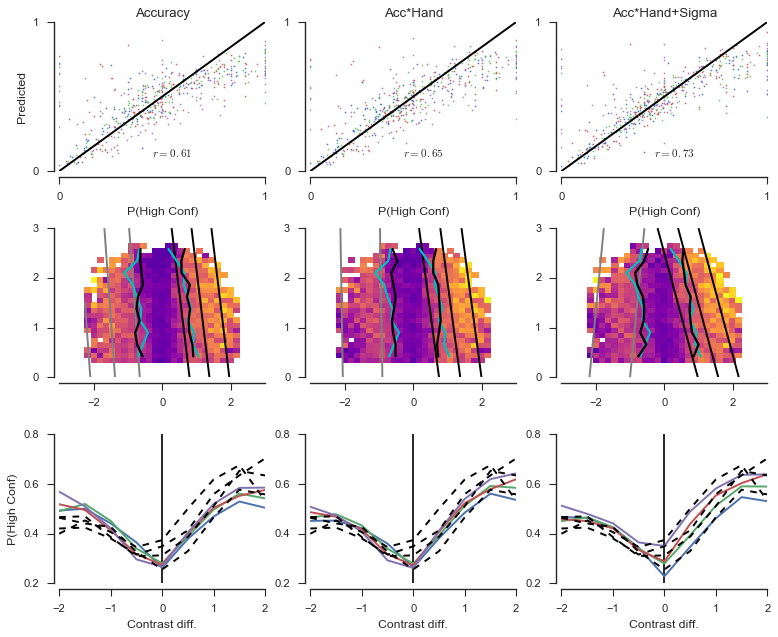

In [354]:
import patsy
import statsmodels.api as sm 

def foo(dz, dlin, edges, surface_edges):
    dlin = dlin.copy()
    dz = dz.copy()

    d2 = qcut(dz, edges, 'lincon').set_index(['lincon', 'snum', 'session_num', 'stdcut3'])
    d2 = d2.drop(set(d2.columns) - set(['response', 'confidence', 'correct', 'conf_0index', 'session_num', 'trial', 'mc', 'stdc']), axis=1)
    dlinavg = dlin.groupby(['lincon', 'snum', 'session_num', 'stdcut3']).mean()
    dlinavg = dlinavg.drop(set(dlinavg.columns) - set(['correct']), axis=1)
    d2 = d2.join(dlinavg, rsuffix='agg')
    d2 = d2.reset_index()
    idnan = isnan(d2.conf_0index.values) | isnan(d2.lincon.values)
    d2.loc[:, 'rside'] = (d2.lincon>0).astype(float)
    d2 = d2.loc[~idnan, :]    
    #+  C(snum)/(C(noise_sigma)
    formulas = {
        'Full':
            'conf_0index ~  C(snum)/(correctagg*C(response)*C(stdcut3)) + C(snum)/(C(session_num)) + C(snum)/abs(mc) + C(snum) + 1',
        'Intermediate':
            'conf_0index ~  C(snum)/(correctagg*C(response))  +  C(snum)/(C(stdcut3)*correctagg) + C(snum)/(C(session_num)) + 1',
        'Rich':
            'conf_0index ~  C(snum)/(correctagg*C(response))  + C(snum)/(C(session_num)) + C(snum)/abs(mc) + 1',
        'Linear':
            'conf_0index ~  C(snum)/(correctagg) + C(snum)/(C(session_num)) + C(snum)/abs(mc)+ 1',
        'Baseline':
            'conf_0index ~  C(snum) + 1'}


    figure(figsize=(16, 8))
    models = {}
    gs = matplotlib.gridspec.GridSpec(3, 5)
    titles = {'Baseline':'Intercept only', 'Linear':'Accuracy', 
              'Rich': 'Acc*Hand', 'Full':'Acc*Hand+Sigma',
              'Intermediate':'No Full interac'}
    d2 = d2.dropna(subset=['conf_0index', 'correctagg', 'rside', 'stdcut3'])
    iso_conf_contour = get_iso_contour(dz, side=1, nbins=10).groupby('STD').mean().reset_index()
    iso_conf_contour_neg = get_iso_contour(dz, side=-1, nbins=10).groupby('STD').mean().reset_index()

    for i, name in enumerate(['Linear', 'Rich', 'Full']):
        y, X = patsy.dmatrices(formulas[name], data=d2)
        mdl_full = sm.formula.Logit(y, X).fit(maxiter=100)
        print 'Model r**2:', mdl_full.prsquared
        models[name] = mdl_full
        #print mdl_full.df_model, mdl_full.df_resid, mdl_full.rsquared
        y = mdl_full.predict(X)
        d2.loc[:, 'predicted_conf'] = y

        
        subplot(gs[0, i])
        title(titles[name])
        davg = d2.groupby(['lincon', 'snum', 'session_num', 'stdcut3']).mean()
        rsqs = []
        for (k, ns), c in davg.groupby(level=['snum', 'stdcut3']):
            m = pd.pivot_table(c.reset_index(), index='lincon', columns='stdcut3', values='conf_0index')
            m2 = pd.pivot_table(c.reset_index(), index='lincon', columns='stdcut3', values='predicted_conf')
            plot(m, m2, '.', color=palette[ns], ms=3, rasterized=True)
            if m2.values.std() > 8.06558328189e-10: 
                #print m2.values, m.values
                s, inter, r, p, ss = linregress(m.values.ravel(), m2.values.ravel())
                rsqs.append(r)       
        plot([0,1], [0,1], 'k')
        print name, 'Mean r', mean(rsqs), 'Number of parameters:', X.shape[1]
        text(0.45, 0.1, r'$r=%1.2f$'%round(mean(rsqs),2))
        #plot(davg.conf_0index, davg.predicted_conf, '.')
        xlabel('P(High Conf)')
        ylabel('Predicted')
        xticks([0, 1])
        yticks([0, 1])
        #plt.locator_params(nbins=4)
        if i > 0:
            ylabel('')
        
        subplot(gs[1,i])
        d2.loc[:, 'predicted1_conf'] = (d2.loc[:, 'predicted_conf']>0.5).astype(float)+1
        d2.loc[:, 'predicted0_conf'] = (d2.loc[:, 'predicted_conf']>0.5).astype(float)
        conf_surface(d2, surface_edges, field='predicted1_conf', 
                    cmap='plasma', vmin=-0.2, vmax=1., mincnt=10)
        confidence_borders(d2, field='predicted0_conf')  
        
        plot(iso_conf_contour['Mean contrast point'].values, iso_conf_contour.STD.values, color='c', lw=2)
        plot(iso_conf_contour_neg['Mean contrast point'].values, iso_conf_contour.STD.values, color='c', lw=2)

        iso_conf_pred = get_iso_contour(d2, side=1, nbins=10, 
                                        field='predicted_conf').groupby('STD').mean().reset_index()
        plot(iso_conf_pred['Mean contrast point'].values, iso_conf_pred.STD.values, color='k', lw=2)
        iso_conf_pred = get_iso_contour(d2, side=-1, nbins=10, 
                                        field='predicted_conf').groupby('STD').mean().reset_index()
        plot(iso_conf_pred['Mean contrast point'].values, iso_conf_pred.STD.values, color='k', lw=2)
        
        xlim([-3, 3])
        plt.locator_params(nbins=4)
        subplot(gs[2, i])
        
        #g = sns.pointplot(x='lincon', y='predicted_conf', hue='stdcut3', units='snum', ci=1, 
        #              data=davg.reset_index(), palette=palette, markers='')
        #for a in g.lines:
        #    a.set_linewidth(1)
        ooo = pd.pivot_table(index='lincon', values='predicted_conf', columns='stdcut3', data=d2.reset_index())
        plot(ooo.index.values, ooo.values)

        ooo = pd.pivot_table(index='lincon', values='conf_0index', columns='stdcut3', data=d2.reset_index())
        plot(ooo.index.values, ooo.values, 'k--')

        ylabel('P(High Conf)')
        xlabel('Contrast diff.')
        legend('')
        #ylim([0.2, 0.8])
        plt.locator_params(nbins=4)
        zpos = mean(xlim())
        axvline(zpos, color='k', lw=1.5, zorder=-inf)
        sns.despine(ax=gca())
        
        if i > 0:
            ylabel('')
    
    
    tight_layout()    
    sns.despine(offset=5)
    #savefig('/Users/nwilming/u/conf_analysis/plots/model_comparison_binned.pdf', bbox_inches='tight')
    savefig('/Users/nwilming/u/conf_analysis/plots/model_comparison_binned.svg', bbox_inches='tight', dpi=1200)
    savefig('/Users/nwilming/u/conf_analysis/plots/model_comparison_binned.png', bbox_inches='tight', dpi=600)
    return models, d2, X



models, d2, X = foo(dz.query('snum>-1'), dlin.query('snum>-1'), edges, surface_bins)

In [355]:
ranking = [models.keys()[x] for x in argsort([m.bic for m in models.values()])]
ranking_aic = [models.keys()[x] for x in argsort([m.aic for m in models.values()])]
print 'BIC results:', ranking
aics = [models[r].bic-models[ranking[0]].bic for r in ranking[1:]]
print aics

print 'AIC results:', ranking_aic
aics = [models[r].aic-models[ranking_aic[0]].aic for r in ranking_aic[1:]]
print aics

BIC results: ['Rich', 'Linear', 'Full']
[241.08677589486615, 1253.4794651307602]
AIC results: ['Full', 'Rich', 'Linear']
[271.97545298831392, 767.30471523635788]


In [144]:
import re
a = re.compile("C\(snum\)\[\d+\]:correctagg$")

a.match('C(snum)[15]:correctagg:C(rside)[T.True]')

In [356]:
help(res.wald_test)

Help on method wald_test in module statsmodels.base.model:

wald_test(self, r_matrix, cov_p=None, scale=1.0, invcov=None, use_f=None) method of statsmodels.discrete.discrete_model.LogitResults instance
    Compute a Wald-test for a joint linear hypothesis.
    
    Parameters
    ----------
    r_matrix : array-like, str, or tuple
        - array : An r x k array where r is the number of restrictions to
          test and k is the number of regressors. It is assumed that the
          linear combination is equal to zero.
        - str : The full hypotheses to test can be given as a string.
          See the examples.
        - tuple : A tuple of arrays in the form (R, q), ``q`` can be
          either a scalar or a length p row vector.
    cov_p : array-like, optional
        An alternative estimate for the parameter covariance matrix.
        If None is given, self.normalized_cov_params is used.
    scale : float, optional
        Default is 1.0 for no scaling.
    invcov : array-like

(299, 3)


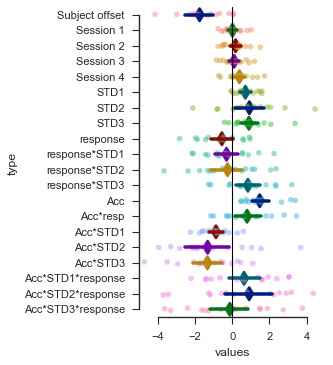

In [353]:
figure(figsize=(3, 5))
res = models['Full']
labels = res.model.exog_names

patterns = {'Subject offset': re.compile("C\(snum\)\[T\.\d+\]$"),
            
            'Session 1': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.1\]$"),
            'Session 2': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.2\]$"),
            'Session 3': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.3\]$"),
            'Session 4': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.4\]$"),
            
            'STD1':re.compile("C\(snum\)\[\d+\]:C\(stdcut3\)\[T\.1\.0\]$"),
            'STD2':re.compile("C\(snum\)\[\d+\]:C\(stdcut3\)\[T\.2\.0\]$"),
            'STD3':re.compile("C\(snum\)\[\d+\]:C\(stdcut3\)\[T\.3\.0\]$"),
            
            'response':re.compile("C\(snum\)\[\d+\]:C\(response\)\[T\.1\.0\]$"),

            'response*STD1':re.compile("C\(snum\)\[\d+\]:C\(response\)\[T\.1\.0\]:C\(stdcut3\)\[T\.1\.0\]$"),
            'response*STD2':re.compile("C\(snum\)\[\d+\]:C\(response\)\[T\.1\.0\]:C\(stdcut3\)\[T\.2\.0\]$"),
            'response*STD3':re.compile("C\(snum\)\[\d+\]:C\(response\)\[T\.1\.0\]:C\(stdcut3\)\[T\.3\.0\]$"),
            
            'Acc':re.compile("C\(snum\)\[\d+\]:correctagg$"),
            'Acc*resp':re.compile("C\(snum\)\[\d+\]:correctagg:C\(response\)\[T\.1\.0\]$"),
            
            'Acc*STD1':re.compile("C\(snum\)\[\d+\]:correctagg:C\(stdcut3\)\[T\.1\.0\]$"),
            'Acc*STD2':re.compile("C\(snum\)\[\d+\]:correctagg:C\(stdcut3\)\[T\.2\.0\]$"),
            'Acc*STD3':re.compile("C\(snum\)\[\d+\]:correctagg:C\(stdcut3\)\[T\.3\.0\]$"),
            #C(snum)[1]:correctagg:C(response)[T.1.0]:C(stdcut3)[T.1.0]
            'Acc*STD1*response':re.compile("C\(snum\)\[\d+\]:correctagg:C\(response\)\[T\.1\.0\]:C\(stdcut3\)\[T\.1\.0\]$"),
            'Acc*STD2*response':re.compile("C\(snum\)\[\d+\]:correctagg:C\(response\)\[T\.1\.0\]:C\(stdcut3\)\[T\.2\.0\]$"),
            'Acc*STD3*response':re.compile("C\(snum\)\[\d+\]:correctagg:C\(response\)\[T\.1\.0\]:C\(stdcut3\)\[T\.3\.0\]$"),
           }


label_order = ['Subject offset', 
          'Session 1', 'Session 2','Session 3', 'Session 4', 
          'STD1', 'STD2', 'STD3',
          'response',  
          'response*STD1', 'response*STD2', 'response*STD3',
           'Acc',
          'Acc*resp',
          'Acc*STD1', 'Acc*STD2','Acc*STD3',
          'Acc*STD1*response', 'Acc*STD2*response', 'Acc*STD3*response']
df = []
for j, name in enumerate(label_order):
    pattern = patterns[name]
    sub_id = [i for i, l in enumerate(labels) if pattern.match(l)]
    params = res.params
    csub = params[sub_id]
    df.append(pd.DataFrame({'values':csub, 'type':name, 'snum':arange(len(csub))}))
    #plot([j]*len(csub), csub, 'o', label=name)
    
df = pd.concat(df)
print df.shape
sns.pointplot(y='type', x='values', units='snum', data=df, join=False, palette="dark",
              markers="d", ci=95)
sns.stripplot(y="type", x="values", 
              data=df, dodge=True, jitter=True,
              alpha=.5, zorder=1)
axvline(0, color='k', linewidth=1)
xlim(-5, 5)
sns.despine(trim=True)
savefig('/Users/nwilming/u/conf_analysis/plots/full_model_coefficients.svg')

In [308]:
X.design_info

DesignInfo(['Intercept',
            'C(snum)[T.2]',
            'C(snum)[T.3]',
            'C(snum)[T.4]',
            'C(snum)[T.5]',
            'C(snum)[T.6]',
            'C(snum)[T.7]',
            'C(snum)[T.8]',
            'C(snum)[T.9]',
            'C(snum)[T.10]',
            'C(snum)[T.11]',
            'C(snum)[T.12]',
            'C(snum)[T.13]',
            'C(snum)[T.14]',
            'C(snum)[T.15]',
            'C(snum)[1]:C(response)[T.1.0]',
            'C(snum)[2]:C(response)[T.1.0]',
            'C(snum)[3]:C(response)[T.1.0]',
            'C(snum)[4]:C(response)[T.1.0]',
            'C(snum)[5]:C(response)[T.1.0]',
            'C(snum)[6]:C(response)[T.1.0]',
            'C(snum)[7]:C(response)[T.1.0]',
            'C(snum)[8]:C(response)[T.1.0]',
            'C(snum)[9]:C(response)[T.1.0]',
            'C(snum)[10]:C(response)[T.1.0]',
            'C(snum)[11]:C(response)[T.1.0]',
            'C(snum)[12]:C(response)[T.1.0]',
            'C(snum)[13]:C(respons

ValueError: Empty data passed with indices specified.

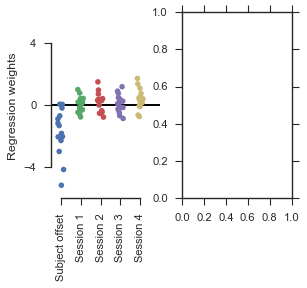

In [349]:
figure(figsize=(6, 3))
import re
res = models['Full']
labels = res.model.exog_names

patterns = {'Subject offset': re.compile("C\(snum\)\[T\.\d+\]"),
            'Session 1': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.1\]"),
            'Session 2': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.2\]"),
            'Session 3': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.3\]"),
            'Session 4': re.compile("C\(snum\)\[\d+\]:C\(session_num\)\[T.4\]"),
            'Contrast sign': re.compile("C\(snum\)\[\d+\]:C\(rside\)\[T\.True\]"),
            r'$\sigma=0.1$': re.compile("C\(snum\)\[\d+\]:C\(noise_sigma\)\[T\.0\.10000000000000001\]"),
            r'$\sigma=0.15$': re.compile("C\(snum\)\[\d+\]:C\(noise_sigma\)\[T\.0\.14999999999999999\]"),
            'Accuracy': re.compile("C\(snum\)\[\d+\]:correctagg$"),
            'Acc.*Contrast sign': re.compile("C\(snum\)\[\d+\]:correctagg:C\(rside\)\[T\.True\]")
           }

offset_patterns = ['Subject offset', 'Session 1', 'Session 2', 'Session 3' ,'Session 4']
subplot(1,3,1)
df = []
for j, name in enumerate(offset_patterns):
    pattern = patterns[name]
    sub_id = [i for i, l in enumerate(labels) if pattern.match(l)]
    params = res.params
    csub = params[sub_id]

    df.append(pd.DataFrame({'values':csub, 'type':name}, index=arange(len(csub))))
    #plot([j]*len(csub), csub, 'o', label=name)
df = pd.concat(df)
sns.stripplot(x='type', y='values', data=df, jitter=.15);
xticks(range(len(offset_patterns)), offset_patterns, rotation=90)
xlim(-0.5, 5)
axhline(0, color='k')
ylim([-6, 6])
sns.despine(trim=True)
ylabel('Regression weights')
xlabel('')
plt.locator_params(axis='y', nbins=4)

offset_patterns = ['Accuracy', 'Contrast sign', 'Acc.*Contrast sign']
sns.despine(trim=True)

subplot(1,3,2)
df = []
for j, name in enumerate(offset_patterns):
    pattern = patterns[name]
    sub_id = [i for i, l in enumerate(labels) if pattern.match(l)]
    params = res.params
    csub = params[sub_id]

    df.append(pd.DataFrame({'values':csub, 'type':name}, index=arange(15)))
    #plot([j]*len(csub), csub, 'o', label=name)
df = pd.concat(df)
#sns.boxplot(x='type', y='values', data=df);
sns.stripplot(x='type', y='values', data=df, jitter=.15, alpha=1);
xticks(range(len(offset_patterns)), offset_patterns, rotation=90)
#xlim(-0.5, 5)
axhline(0, color='k')
ylim([-7, 7])
plt.locator_params(nbins=6)

sns.despine(trim=True)
ylabel('')
xlabel('')

subplot(1,3,3)
offset_patterns =[r'$\sigma=0.1$' ,r'$\sigma=0.15$']
df = []
for j, name in enumerate(offset_patterns):
    pattern = patterns[name]
    sub_id = [i for i, l in enumerate(labels) if pattern.match(l)]
    params = res.params
    csub = params[sub_id]

    df.append(pd.DataFrame({'values':csub, 'type':name}, index=arange(15)))
    #plot([j]*len(csub), csub, 'o', label=name)
df = pd.concat(df)
#sns.boxplot(x='type', y='values', data=df);
sns.stripplot(x='type', y='values', data=df, jitter=.15, alpha=1);
xticks(range(len(offset_patterns)), offset_patterns, rotation=90)
#xlim(-0.5, 2)
axhline(0, color='k')
ylim([-1.5, 1.5])
plt.locator_params(nbins=4)

sns.despine(trim=True)
ylabel('')
xlabel('')
tight_layout()

savefig('/Users/nwilming/u/conf_analysis/plots/model_full_weights.pdf', bbox_inches='tight')


conf_0index ~  C(snum) + 1
Optimization terminated successfully.
         Current function value: 0.635466
         Iterations 5
0.0574295378563
conf_0index ~  C(snum)/(abs(mc)*C(session_num)) + 1
Optimization terminated successfully.
         Current function value: 0.605135
         Iterations 7
0.102418471622
conf_0index ~  C(snum)/(abs(mc)*C(rside)*C(session_num)) + 1
Optimization terminated successfully.
         Current function value: 0.590658
         Iterations 8
0.123891871542
conf_0index ~  C(snum)/(abs(mc)*C(noise_sigma)*C(rside)*C(session_num)) + 1
Optimization terminated successfully.
         Current function value: 0.574213
         Iterations 9
0.148284137446


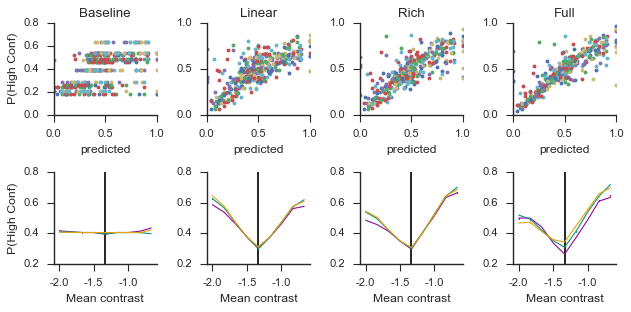

In [127]:
idnan = isnan(dz.conf_0index.values) | isnan(dz.mc.values)
dz.loc[:, 'rside'] = dz.mc>0
d2 = dz.loc[~idnan, :]
formulas = {'Full':
                'conf_0index ~  C(snum)/(abs(mc)*C(noise_sigma)*C(rside)*C(session_num)) + 1',
            'Rich':
                'conf_0index ~  C(snum)/(abs(mc)*C(rside)*C(session_num)) + 1',
            'Linear':
                'conf_0index ~  C(snum)/(abs(mc)*C(session_num)) + 1',
            'Baseline':
                'conf_0index ~  C(snum) + 1'}
            

figure(figsize=(8, 4))
models = {}
gs = matplotlib.gridspec.GridSpec(2, 4)
for i, name in enumerate(['Baseline', 'Linear', 'Rich', 'Full']):

    print formulas[name]
    y, X = patsy.dmatrices(formulas[name], data=d2, eval_env=0)
    mdl_full = sm.formula.Logit(y, X).fit(maxiter=100)
    
    print mdl_full.prsquared
    models[name] = mdl_full
    #print mdl_full.df_model, mdl_full.df_resid, mdl_full.rsquared
    y = mdl_full.predict(X)
    #print mdl_full.summary()
    d2.loc[:, 'predicted_conf'] = y
    
    
    subplot(gs[0, i])
    title(name)
    davg = d2.groupby(['lincon', 'snum', 'session_num', 'stdcut3']).mean()
    for k, c in davg.groupby(level=['snum']):
        m = pd.pivot_table(c.reset_index(), index='lincon', columns='stdcut3', values='conf_0index')
        m2 = pd.pivot_table(c.reset_index(), index='lincon', columns='stdcut3', values='predicted_conf')
        plot(m, m2, '.')
    #plot(davg.conf_0index, davg.predicted_conf, '.')
    ylabel('P(High Conf)')
    xlabel('predicted')
    plt.locator_params(nbins=4)
    if i > 0:
        ylabel('')
    subplot(gs[1, i])
    g = sns.pointplot(x='lincon', y='predicted_conf', hue='stdcut3', units='snum', ci=1, 
                  data=davg.reset_index(), palette=palette, markers='')
    for a in g.lines:
        a.set_linewidth(1)
    ylabel('P(High Conf)')
    xlabel('Mean contrast')
    legend('')
    ylim([0.2, 0.8])
    plt.locator_params(nbins=4)
    zpos = mean(xlim())
    axvline(zpos, color='k', lw=1.5, zorder=-inf)
    sns.despine(ax=gca())

    #ylim([0, 1])
    #xlim([0, 1])
    if i > 0:
        ylabel('')

tight_layout()
sns.despine()
savefig('/Users/nwilming/u/conf_analysis/plots/model_comparison_mc_based.pdf', bbox_inches='tight') 

## d' and criterion as function of evidence and noise

To compute d' and criterion I conceptualize the task as asking 'Is the contrast of the second stimulus above the reference?'. This yields to the following definitions:


|       | Above | Below |
| ----- |:-----:| -----:|
| **Above** | Hit   | FA    |
| **Below** | Miss  | CR    |

$$d' = z(Hit) - z(FA)$$
$$c = -\frac{1}{2}(z(Hit) + z(FA))$$


In [63]:
from scipy.stats import linregress
from scipy.stats import ttest_1samp

Mean criterion slope: -0.00219586953155
p: -0.05202
Mean d' slope: 0.173192605466
p: 0.80043
Mean hit vs. fa slope: 0.64992617248
p: 7.192e-07


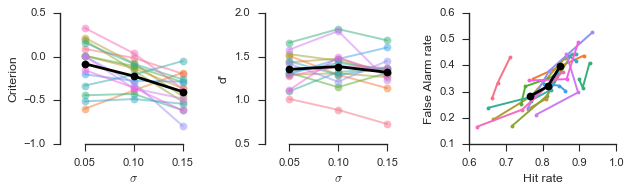

In [64]:

figure(figsize=(8,2.5))
with sns.color_palette("husl", 15):
    subplot(1, 3,1)
    t1 =(data.groupby(['snum', 'noise_sigma'])
             .apply(empirical.crit).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    plot(t1.index.values, t1.values, 'o-', alpha=0.5)
    plot(t1.index.values, t1.values.mean(1), 'ko-', lw=2.5)
    slopes = []
    for k in t1.values.T:
        slopes.append(linregress(k, [0.01, 0.10, 0.15])[1])
    print 'Mean criterion slope:', mean(slopes)
    print 'p:',  round(ttest_1samp(slopes, 0)[0], 5)
    plt.locator_params(nbins=4)
    ylabel('Criterion')
    xlabel(r'$\sigma$')
    xlim([0.025, 0.175])
    subplot(1,3,2)
    t1 =(data.groupby(['snum', 'noise_sigma'])
             .apply(empirical.dp).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    slopes = []
    for k in t1.values.T:
        slopes.append(linregress(k, [0.01, 0.10, 0.15])[1])
    print 'Mean d\' slope:', mean(slopes)
    print 'p:',  round(ttest_1samp(slopes, 0)[0], 5)
    
    plot(t1.index.values, t1.values, 'o-', alpha=0.5)
    plot(t1.index.values, t1.values.mean(1), 'ko-', lw=2.5)
    plt.locator_params(nbins=4)
    ylabel(r"d'")
    xlabel(r'$\sigma$')
    xlim([0.025, 0.175])
    subplot(1,3,3)
    hit =(data.groupby(['snum', 'noise_sigma'])
             .apply(lambda x: empirical.tbl(x)[0]).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    fa =(data.groupby(['snum', 'noise_sigma'])
             .apply(lambda x: empirical.tbl(x)[1]).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    slopes = []
    for k, c in zip(hit.values.T, fa.values.T):
        slopes.append(linregress(c, k)[1])
    print 'Mean hit vs. fa slope:', mean(slopes)
    print 'p:',  round(ttest_1samp(slopes, 0)[1], 10)
    
    plot(hit, fa, '.-')
    plot(hit.mean(1), fa.mean(1), 'ko-', lw=2.5)
    xlabel('Hit rate')
    ylabel('False Alarm rate')
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=5)
    sns.despine(trim=True)
    tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/fig3_sdt_parameters.pdf')

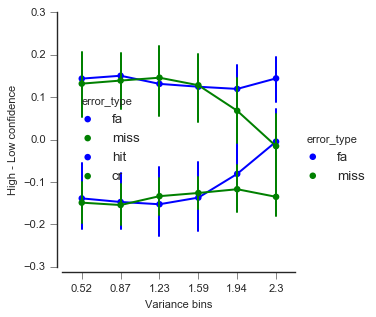

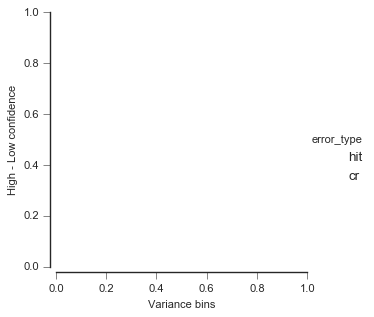

In [121]:
def plot_err_overconf(data, n=7):
    low, high = percentile(data.stdc, [1, 98])
    std_bins = linspace(low, high, n+1)

    def cutme(stdc, bins):
        centers = around([low+(high-low)/2 for low, high in zip(bins[:-1], bins[1:])], 2)
        return pd.cut(stdc, bins, labels=centers)

    data.loc[:, 'stdcut3'] = data.groupby('snum').stdc.apply(lambda x: cutme(x, std_bins))


    def tbl(x):
        hit, fa, miss, cr = empirical.tbl(x)
        return pd.DataFrame({'fa':fa, 'miss':miss}, index=[0])

    dflow = data.groupby(['snum', 'stdcut3', 'confidence']).apply(tbl).reset_index().set_index(['snum', 'stdcut3'])

    l = (dflow.fa-dflow.miss).reset_index()
    l.columns = ['snum', 'stdcut3', 'diff']

    tmp = dflow.loc[dflow.confidence.values==2] - dflow.loc[dflow.confidence.values==1]
    tmp = tmp.loc[:, ('fa', 'miss')].stack().reset_index()
    tmp.columns = ['snum', 'Variance bins', 'error_type', 'High - Low confidence']
    sns.factorplot(y='High - Low confidence', x='Variance bins', hue='error_type', units='snum', data=tmp)
    #ylim([-.2, .1])
    sns.despine(offset=5)
    return tmp


def plot_correct_overconf(data, n=7):
    low, high = percentile(data.stdc, [1, 98])
    std_bins = linspace(low, high, n+1)

    def cutme(stdc, bins):
        centers = around([low+(high-low)/2 for low, high in zip(bins[:-1], bins[1:])], 2)
        return pd.cut(stdc, bins, labels=centers)

    data.loc[:, 'stdcut3'] = data.groupby('snum').stdc.apply(lambda x: cutme(x, std_bins))


    def tbl(x):
        hit, fa, miss, cr = empirical.tbl(x)
        return pd.DataFrame({'hit':hit, 'cr':cr}, index=[0])

    dflow = data.groupby(['snum', 'stdcut3', 'confidence']).apply(tbl).reset_index().set_index(['snum', 'stdcut3'])

    l = (dflow.hit-dflow.cr).reset_index()
    l.columns = ['snum', 'stdcut3', 'diff']

    tmp = dflow.loc[dflow.confidence.values==2] - dflow.loc[dflow.confidence.values==1]
    tmp = tmp.loc[:, ('hit', 'cr')].stack().reset_index()
    tmp.columns = ['snum', 'Variance bins', 'error_type', 'High - Low confidence']
    sns.factorplot(y='High - Low confidence', x='Variance bins', hue='error_type', units='snum', data=tmp, ax=gca())
    #ylim([-.2, .1])
    sns.despine(offset=5)
    return tmp

tmp = plot_err_overconf(dz, 6)
tmp2 = plot_correct_overconf(dz, 6)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
kd = tmp#.query('error_type=="fa"')
kd.columns = ['snum', 'variance', 'type', 'overconfidence']
#ranova_rm('overconfidence', ['variance', 'type'], kd)
savefig('/Users/nwilming/u/conf_analysis/plots/high_conf_errors.svg')
savefig('/Users/nwilming/u/conf_analysis/plots/high_conf_errors.png')

In [122]:
def plot_correct_overconf(data, n=7):
    low, high = percentile(data.stdc, [1, 98])
    std_bins = linspace(low, high, n+1)

    def cutme(stdc, bins):
        centers = around([low+(high-low)/2 for low, high in zip(bins[:-1], bins[1:])], 2)
        return pd.cut(stdc, bins, labels=centers)

    data.loc[:, 'stdcut3'] = data.groupby('snum').stdc.apply(lambda x: cutme(x, std_bins))


    def tbl(x):
        hit, fa, miss, cr = empirical.tbl(x)
        return pd.DataFrame({'hit':hit, 'cr':cr}, index=[0])

    dflow = data.groupby(['snum', 'stdcut3', 'confidence']).apply(tbl).reset_index().set_index(['snum', 'stdcut3'])

    l = (dflow.hit-dflow.cr).reset_index()
    l.columns = ['snum', 'stdcut3', 'diff']

    tmp = dflow.loc[dflow.confidence.values==2] - dflow.loc[dflow.confidence.values==1]
    tmp = tmp.loc[:, ('hit', 'cr')].stack().reset_index()
    tmp.columns = ['snum', 'Variance bins', 'error_type', 'High - Low confidence']
    sns.factorplot(y='High - Low confidence', x='Variance bins', hue='error_type', units='snum', data=tmp)
    #ylim([-.2, .1])
    sns.despine(offset=5)
    return tmp



   snum  level_1  Mean contrast point   STD       type
0     1        0             1.750000  0.45  test_conf
1     1        1             1.287081  0.75  test_conf
2     1        2            -0.230861  1.05  test_conf
3     1        3             1.330144  1.35  test_conf
4     1        4             1.351675  1.65  test_conf
(0.45000000000000001, 2.5499999999999998)


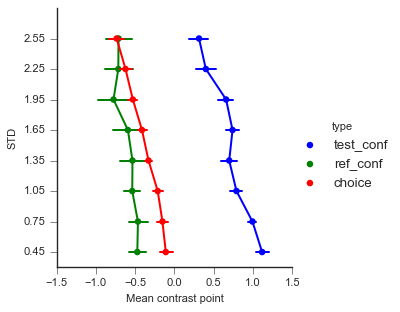

In [218]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

dz.loc[:,'conf0_index'] = dz.confidence-1
def get_iso_contour(dz, varmax=3, nbins=11, side=1, which='conf', field='conf0_index'):
    if side==1:
        label='test'
    else:
        label='ref'
        
        
    def cutme(stdc, bins):
        centers = around([low+(high-low)/2 for low, high in zip(bins[:-1], bins[1:])], 2)
        return pd.cut(stdc, bins, labels=centers)

    low, high = percentile(dz.stdc, [0, 99])
    std_bins = linspace(low, high, nbins+1)
    std_bins = linspace(0.3, 2.7, nbins+1)
    data.loc[:, 'stdcut3'] = data.groupby('snum').stdc.apply(lambda x: cutme(x, std_bins))

    def continuous_bins(x, centers, dt, field='mc'):
        for center in centers:
            low, high = center-dt, center+dt
            idx = (low<x[field].values) & (x[field].values<high)
            yield center, x.loc[idx, :]

    def get_iso_choice(dz, iso_c=0, dt=0.1):
        log_res, results = empirical.fit_logistic(dz, 'R ~ 1', summary=False)   
        return -results.params['Intercept']
            
    def get_iso_conf_gauss(dz, iso_c=0.3, dt=0.1):
        mc_centers = side*linspace(-0.5, 1.75, 15)
        choice = array([nanmean(dx[field].values) 
                      for center, dx in continuous_bins(dz, mc_centers, dt=dt, field='mc')])
        idx = isnan(choice)
        
        def gauss(x, *p):
            A, mu, sigma, b = p
            return (A*numpy.exp(-(x-mu)**2/(2.*sigma**2)))+b

        p0 = [0.3, 0., 1., 0.3]
        try:
            coeff, var_matrix = curve_fit(gauss, mc_centers[~idx], choice[~idx], p0=p0, maxfev=5000, xtol=1.49012e-02)
        except RuntimeError as e:
            coeff, var_matrix = curve_fit(gauss, mc_centers[~idx], choice[~idx], p0=p0, maxfev=5000, xtol=1.49012e-01)
        if any(isinf(gauss(mc_centers, *coeff))):
            return mc_centers, choice
        
        mc_centers = linspace(mc_centers[~idx].min(), mc_centers[~idx].max(), 210)
        y = gauss(mc_centers, *coeff)
        return mc_centers[argmin(abs(y-iso_c))], mc_centers, y

    
    def get_iso_choice_by_var(dz, iso_c=0.3, dt=0.1, dtm=0.5):
        iso_choice = array([get_iso_choice(dx, 0, dtm)
              for center, dx in continuous_bins(dz, std_centers, dt=dt, field='stdc')])
        return pd.DataFrame({'iso_point':iso_choice, 'stdc':std_centers, 'type':'choice'})
    
    
    def get_iso_conf_by_var(dz, iso_c=0.3, dt=0.1, dtm=0.5):
        if iso_c == 'mean':
            if side > 0:
                iso_c = dz.query('mc>0')[field].mean()
            else:
                iso_c = dz.query('mc<0')[field].mean()
        isoc = array([get_iso_conf_gauss(dx, iso_c, dtm)[0]
                      for center, dx in continuous_bins(dz, std_centers, dt=dt, field='stdc')])            
        return pd.DataFrame({'iso_conf':isoc, 'stdc':std_centers, 'type':label+'_conf'})
    
    dt = 0.55
    dtm = 0.55
    std_centers = around(
            [low+(high-low)/2 
                 for low, high in zip(std_bins[:-1], std_bins[1:])], 2)

    
    if which=='conf':
        o = dz.groupby([ 'snum']).apply(lambda x: 
                                    get_iso_conf_by_var(x, iso_c='mean', dt=dt, dtm=dtm)
                                   ).reset_index()
    else:
        o = dz.groupby([ 'snum']).apply(lambda x: 
                                    get_iso_choice_by_var(x, iso_c='mean', dt=dt, dtm=dtm)
                                   ).reset_index()
    o.columns = ['snum', 'level_1', 'Mean contrast point', 'STD', 'type',]
    return o


n=8
iso_conf_contour = get_iso_contour(dz, nbins=n)
iso_conf_contour_neg = get_iso_contour(dz, side=-1, nbins=n)
iso_choice = get_iso_contour(dz, nbins=n, which='choice')

#iso_conf_contour_neg['Mean contrast point'] *=-1
iso_conf_contour = pd.concat([iso_conf_contour, iso_conf_contour_neg, iso_choice])

print iso_conf_contour.head()

iso_conf_contour.STD = np.around(iso_conf_contour.STD.values, 2)
yl = iso_conf_contour.reset_index().STD.min(), iso_conf_contour.reset_index().STD.max()
g = sns.factorplot(y='STD', x='Mean contrast point', hue='type', ci=68,
               data=iso_conf_contour.reset_index(), orient='h')
print yl
g.set(ylim=(-0.5, 8))
savefig('/Users/nwilming/u/conf_analysis/plots/iso_conf_boundaries_v.svg')
savefig('/Users/nwilming/u/conf_analysis/plots/iso_conf_boundaries_v.png')

(0.45000000000000001, 2.5499999999999998)

In [208]:
iso_conf_contour.columns = ['snum', 'level_1', 'isoconf', 'STD', 'type']
ranova_rm('isoconf', ['STD', 'type'], iso_conf_contour)


    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, isoconf, wid=snum, within=.(STD,type))
    
$ANOVA
    Effect DFn DFd           F            p p<.05        ges
2      STD   7  98   7.5870919 2.702299e-07     * 0.14770116
3     type   2  28 171.3243635 1.971230e-16     * 0.62301255
4 STD:type  14 196   0.8306586 6.352541e-01       0.02762636

$`Mauchly's Test for Sphericity`
    Effect            W            p p<.05
2      STD 2.909000e-03 5.584906e-05     *
3     type 8.593984e-01 3.734776e-01      
4 STD:type 1.701009e-13 3.306278e-15     *

$`Sphericity Corrections`
    Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF] p[HF]<.05
2      STD 0.4081048 4.747017e-04         * 0.5237115 1.078779e-04         *
3     type 0.8767303 1.152870e-14         * 0.9921950 2.550044e-16         *
4 STD:type 0.2658735 5.046565e-01           0.374132

In [120]:
from scipy.stats import linregress, ttest_rel, ttest_1samp

def get_slope(x):    
    d = pd.pivot_table(index='STD', values='isoconf', data=x)
    s, i, _, _, _ = linregress(d.index.values, d.values)
    return s

ic = iso_conf_contour.groupby(['snum', 'type']).apply(get_slope).reset_index()
ic.columns = ['snum', 'type', 'slope']

for (typelabel, dd) in ic.groupby('type'):
    print ('T-test for %s slope:'%typelabel, ttest_1samp(dd.slope, 0), 'Mean:', dd.slope.mean())

for (typelabel, dd) in ic.groupby('type'):
    for (typelabel2, dk) in ic.groupby('type'):
        if typelabel == typelabel2:
            continue
        print '%s vs %s:'%(typelabel, typelabel2), ttest_rel(dd.slope, dk.slope)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [84]:
0.05/2

0.025

0.444335990456


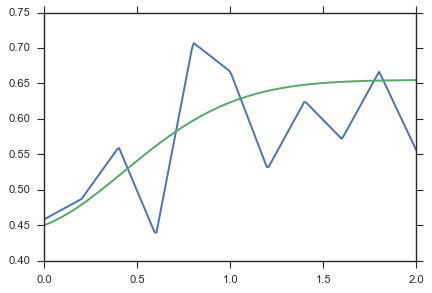

In [55]:
from scipy.optimize import curve_fit
side=1
def cutme(stdc, bins):
    centers = around([low+(high-low)/2 for low, high in zip(bins[:-1], bins[1:])], 2)
    return pd.cut(stdc, bins, labels=centers)

n=12
low, high = percentile(data.stdc, [5, 95])
std_bins = linspace(low, high, n+1)
data.loc[:, 'stdcut3'] = data.groupby('snum').stdc.apply(lambda x: cutme(x, std_bins))

def continuous_bins(x, centers, dt, field='stdc'):
    for center in centers:
        low, high = center-dt, center+dt
        idx = (low<x[field].values) & (x[field].values<high)
        yield center, x.loc[idx, :]


def get_iso_conf(dz, iso_c=0.3, dt=0.1):
    mc_centers = side*linspace(0, 2, 11)
    choice = array([nanmean(dx.conf0_index.values) 
                  for center, dx in continuous_bins(dz, mc_centers, dt=dt, field='mc')])
    idx = isnan(choice)
    f = interp1d(mc_centers[~idx], choice[~idx], kind='linear')
    mc_centers = linspace(mc_centers[~idx].min(), mc_centers[~idx].max(), 210)
    y = f(mc_centers)
    return mc_centers[argmin(abs(y-iso_c))], mc_centers, y

def get_iso_conf_gauss(dz, iso_c=0.3, dt=0.1):
    mc_centers = side*linspace(0, 2, 15)
    choice = array([nanmean(dx.conf0_index.values) 
                  for center, dx in continuous_bins(dz, mc_centers, dt=dt, field='mc')])
    idx = isnan(choice)
    def gauss(x, *p):
        A, mu, sigma, b = p
        return (A*numpy.exp(-(x-mu)**2/(2.*sigma**2)))+b

    p0 = [0.3, 0., 1., 0.3]
    try:
        coeff, var_matrix = curve_fit(gauss, mc_centers[~idx], choice[~idx], p0=p0, maxfev=5000, xtol=1.49012e-02)
    except RuntimeError as e:
        coeff, var_matrix = curve_fit(gauss, mc_centers[~idx], choice[~idx], p0=p0, maxfev=5000, xtol=1.49012e-01)
    if any(isinf(gauss(mc_centers, *coeff))):
        return mc_centers, choice

    mc_centers = linspace(mc_centers[~idx].min(), mc_centers[~idx].max(), 210)
    y = gauss(mc_centers, *coeff)
    return mc_centers[argmin(abs(y-iso_c))], mc_centers, y




mean_conf = dz.query('mc>0').conf0_index.mean()
print mean_conf
i, x, y = get_iso_conf(dz.query('stdc>2.45'), iso_c=mean_conf)
plot(x, y)
i, x, y = get_iso_conf_gauss(dz.query('stdc>2.45'), iso_c=mean_conf)
plot(x, y)

[ 0.025       0.05416667  0.08333333  0.1125      0.14166667  0.17083333
  0.2       ]
0.012320271932 0.286464349831


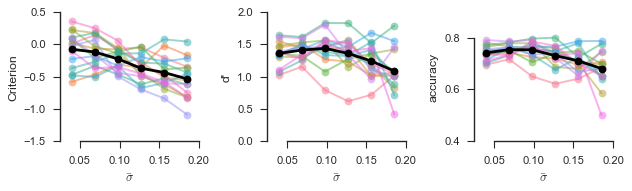

In [65]:
figure(figsize=(8,2.5))
edges = linspace(0.025, 0.2, 7)
#aedges = percentile(data.stdc.values, linspace(10, 90, 9))
print edges
print data.stdc.min(), data.stdc.max()

centers = [low+(high-low)/2. for low, high in zip(edges[:-1], edges[1:])]
data.loc[:, 'binstdc'] = pd.cut(data.stdc, edges, labels=centers)

with sns.color_palette("husl", 15):

    subplot(1,3,1)
    t1_d = (data.groupby(['snum', 'binstdc'])
             .apply(empirical.crit).reset_index()
             .pivot_table(index='binstdc', columns='snum'))

    plot(t1_d.index.values, t1_d.values, 'o-', alpha=0.5)
    plot(t1_d.index.values, nanmean(np.ma.masked_invalid(t1_d.values),1), 'ko-', lw=2.5)
    
    plt.locator_params(nbins=4)
    ylabel(r"Criterion")
    xlabel(r'$\bar\sigma$')
    xlim([0.025, 0.2])

    subplot(1,3,2)
    t1_c = (data.groupby(['snum', 'binstdc'])
             .apply(empirical.dp).reset_index()
             .pivot_table(index='binstdc', columns='snum'))

    plot(t1_c.index.values, t1_c.values, 'o-', alpha=0.5)
    plot(t1_c.index.values, nanmean(np.ma.masked_invalid(t1_c.values),1), 'ko-', lw=2.5)
    plt.locator_params(nbins=4)
    ylabel(r"d'")
    xlabel(r'$\bar\sigma$')
    xlim([0.025, 0.2])
    
    subplot(1,3,3)
    t1 = (data.groupby(['snum', 'binstdc'])
             .correct.mean().reset_index()
             .pivot_table(index='binstdc', columns='snum'))
    
    x = t1.index.get_level_values('binstdc').astype(float)
    plot(x, t1.values, 'o-', alpha=0.5)
    plot(x, nanmean(np.ma.masked_invalid(t1.values),1), 'ko-', lw=2.5)
    plt.locator_params(nbins=4)
    ylabel(r"accuracy")
    xlabel(r'$\bar\sigma$')
    xlim([0.025, 0.2])
tight_layout()
sns.despine(trim=True)
savefig('/Users/nwilming/u/conf_analysis/plots/fig3_sdt_parameters_binned.pdf')

In [66]:
# Do a repeated measures ANOVA in R using ezANOVA




In [67]:
kd = (data.groupby(['snum', 'binstdc'])
             .apply(empirical.crit).reset_index())
kd.columns = ['snum', 'stdc', 'criterion']
kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
kd.loc[:, 'stdc'] = 'T' + kd.stdc.astype(str)
#kd.loc[:, 'noise_sigma'] = 'N' + kd.noise_sigma.astype(str)

kd.to_csv('/Users/nwilming/kernels2.csv')

print 'RM ANOVA in R for CRITERION:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, criterion, wid=snum, within=.(stdc))
'''
print robjects.r(R_cmd)

kd = (data.groupby(['snum', 'binstdc'])
             .apply(empirical.dp).reset_index())
kd.columns = ['snum', 'stdc', 'dprime']
kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
kd.loc[:, 'stdc'] = 'T' + kd.stdc.astype(str)
#kd.loc[:, 'noise_sigma'] = 'N' + kd.noise_sigma.astype(str)

kd.to_csv('/Users/nwilming/kernels2.csv')

print 'RM ANOVA in R for DPRIME:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, dprime, wid=snum, within=.(stdc))
'''
print robjects.r(R_cmd)

kd = (data.groupby(['snum', 'binstdc'])
             .correct.mean().reset_index())
kd.columns = ['snum', 'stdc', 'accuracy']
kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
kd.loc[:, 'stdc'] = 'T' + kd.stdc.astype(str)
#kd.loc[:, 'noise_sigma'] = 'N' + kd.noise_sigma.astype(str)

kd.to_csv('/Users/nwilming/kernels2.csv')

print 'RM ANOVA in R for ACCURACY:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, accuracy, wid=snum, within=.(stdc))
'''
print robjects.r(R_cmd)

RM ANOVA in R for CRITERION:
$ANOVA
  Effect DFn DFd        F            p p<.05       ges
2   stdc   5  70 10.41046 1.712183e-07     * 0.3254578

$`Mauchly's Test for Sphericity`
  Effect           W            p p<.05
2   stdc 0.002267387 7.566166e-10     *

$`Sphericity Corrections`
  Effect       GGe       p[GG] p[GG]<.05       HFe       p[HF] p[HF]<.05
2   stdc 0.2679802 0.002428176         * 0.2859143 0.001907852         *


RM ANOVA in R for DPRIME:
$ANOVA
  Effect DFn DFd        F            p p<.05       ges
2   stdc   5  70 6.838018 3.022664e-05     * 0.1969303

$`Mauchly's Test for Sphericity`
  Effect          W           p p<.05
2   stdc 0.05783231 0.002057703     *

$`Sphericity Corrections`
  Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF] p[HF]<.05
2   stdc 0.5676296 0.0009661928         * 0.7269801 0.0002666334         *


RM ANOVA in R for ACCURACY:
$ANOVA
  Effect DFn DFd        F            p p<.05       ges
2   stdc   5  70 7.965047 5.491922e-06     

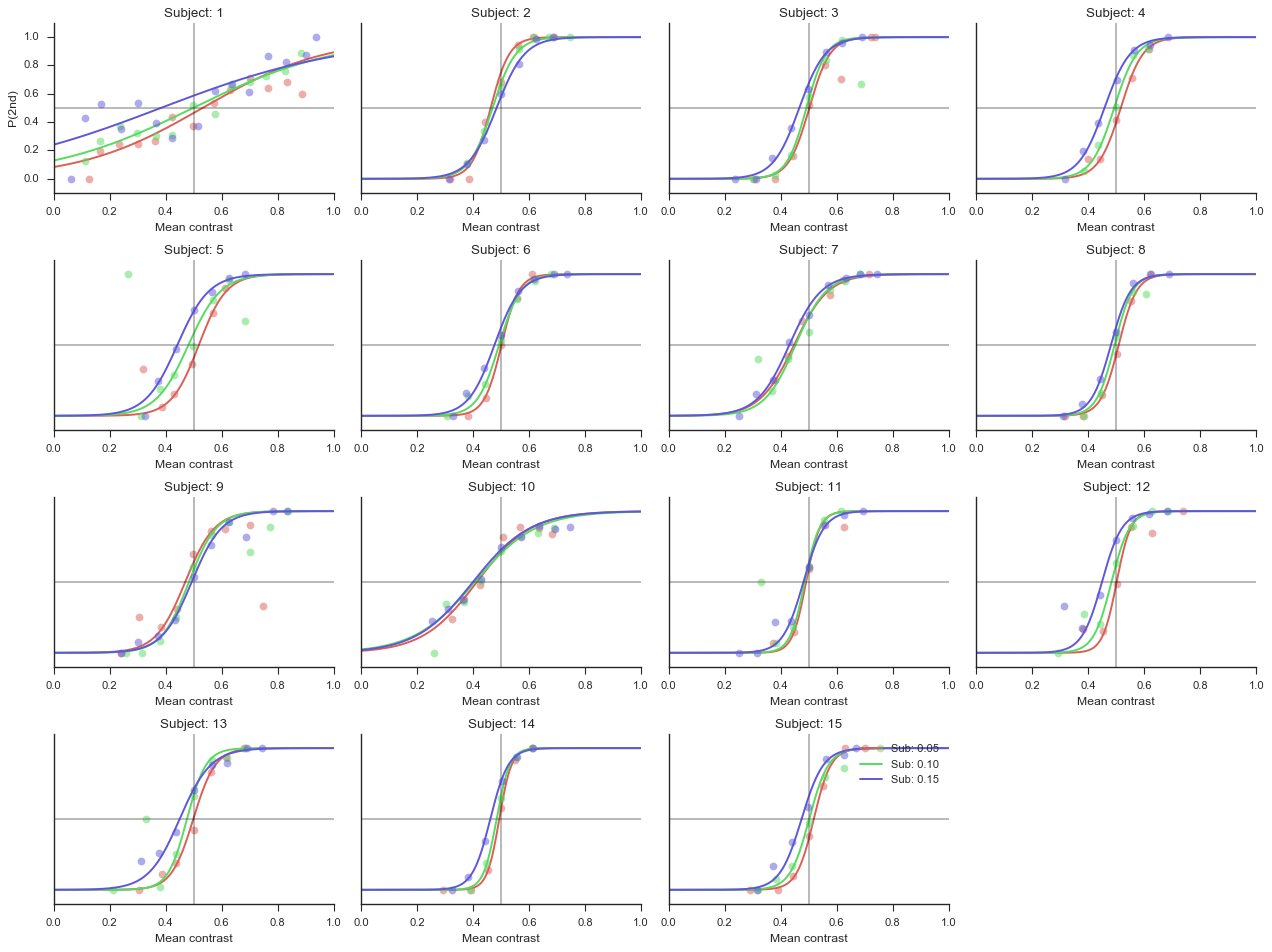

In [68]:
import patsy
import pandas as pd
figure(figsize=(16,12))
x = linspace(0, 1, 1000)
nti = {0.05:0, 0.1:1, 0.15:2}
colors = sns.color_palette("hls", 3)
for (snum, day), sub in data.groupby(['snum', 'noise_sigma']):
    subplot(4,4, snum)
    log_res, results = empirical.fit_logistic(sub, 'R ~ mc + 1', summary=False)
    X = vstack([ones(x.shape), x])
    plot(x, results.predict(X.T), label='Sub: %1.2f'%day, color=colors[nti[day]])

    for c, d in sub.groupby(pd.cut(sub.mc, linspace(0, 1, 16))):
        if len(d) == 0:
            continue
        plot(d.mc.mean(), d.R.sum()/float(len(d)), 'o', color=colors[nti[day]], alpha=0.5)
    ylim([-0.1, 1.1])
    sns.despine()
    ylabel('P(2nd)')
    xlabel('Mean contrast')
    #legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
    plot(xlim(), [0.5, 0.5], 'k', alpha=0.1)
    plot([.5, .5], ylim(), 'k', alpha=0.1)
    if snum>1:
        ylabel('')
        yticks([])
    title('Subject: %i'%snum)

legend()
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/response_curves_var.pdf')

P(14 | binom(n=14, p=0.5)): 0.0


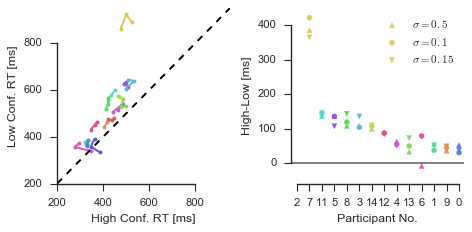

In [69]:
figure(figsize=(6,3))
subplot(1,2,1)
colors = array(sns.color_palette("hls", 15))
drt = ((data.groupby(['snum', 'noise_sigma', 'confidence'])
           .choice_rt.mean()*1000).reset_index())
high = drt.query('confidence==2').pivot_table(index='snum', columns='noise_sigma', values='choice_rt')
low = drt.query('confidence==1').pivot_table(index='snum', columns='noise_sigma', values='choice_rt')
idx = argsort((low.mean(1)-high.mean(1)).values)[::-1]
delta_rt = (low-high).values

for i in idx+1:
    plot(high.loc[i,:], low.loc[i,:], '.-', color=colors[i-1])
plot([0, 1000], [0,1000], 'k--')
plt.locator_params(nbins=4)
ylim([200, 950])
xlim([200, 950])
ylabel(r'Low Conf. RT [ms]')
xlabel(r'High Conf. RT [ms]')
subplot(1,2,2)

scatter(arange(len(idx))+1, delta_rt[idx,0], c=colors[idx], marker='^', label=r'$\sigma=0.5$', edgecolors='face')
scatter(arange(len(idx))+1, delta_rt[idx,1], c=colors[idx], marker='o', label=r'$\sigma=0.1$', edgecolors='face')
scatter(arange(len(idx))+1, delta_rt[idx,2], c=colors[idx], marker='v', label=r'$\sigma=0.15$', edgecolors='face')

legend()
xticks(arange(len(idx)), idx)
xlim([-0.5, 13.4])
ylim([-60, 450])
plot(xlim(), [0, 0], 'k', alpha=0.5)
xlabel(r'Participant No.')
ylabel(r'High-Low [ms]')
sns.despine(trim=True)
tight_layout()

from scipy.stats import binom
cnt = sum(delta_rt.mean(1) > 0)
print 'P(%i | binom(n=14, p=0.5)):'%cnt, 1-binom.cdf(cnt, 14, 0.5 )
savefig('/Users/nwilming/u/conf_analysis/plots/rt_var_and_conf.pdf')

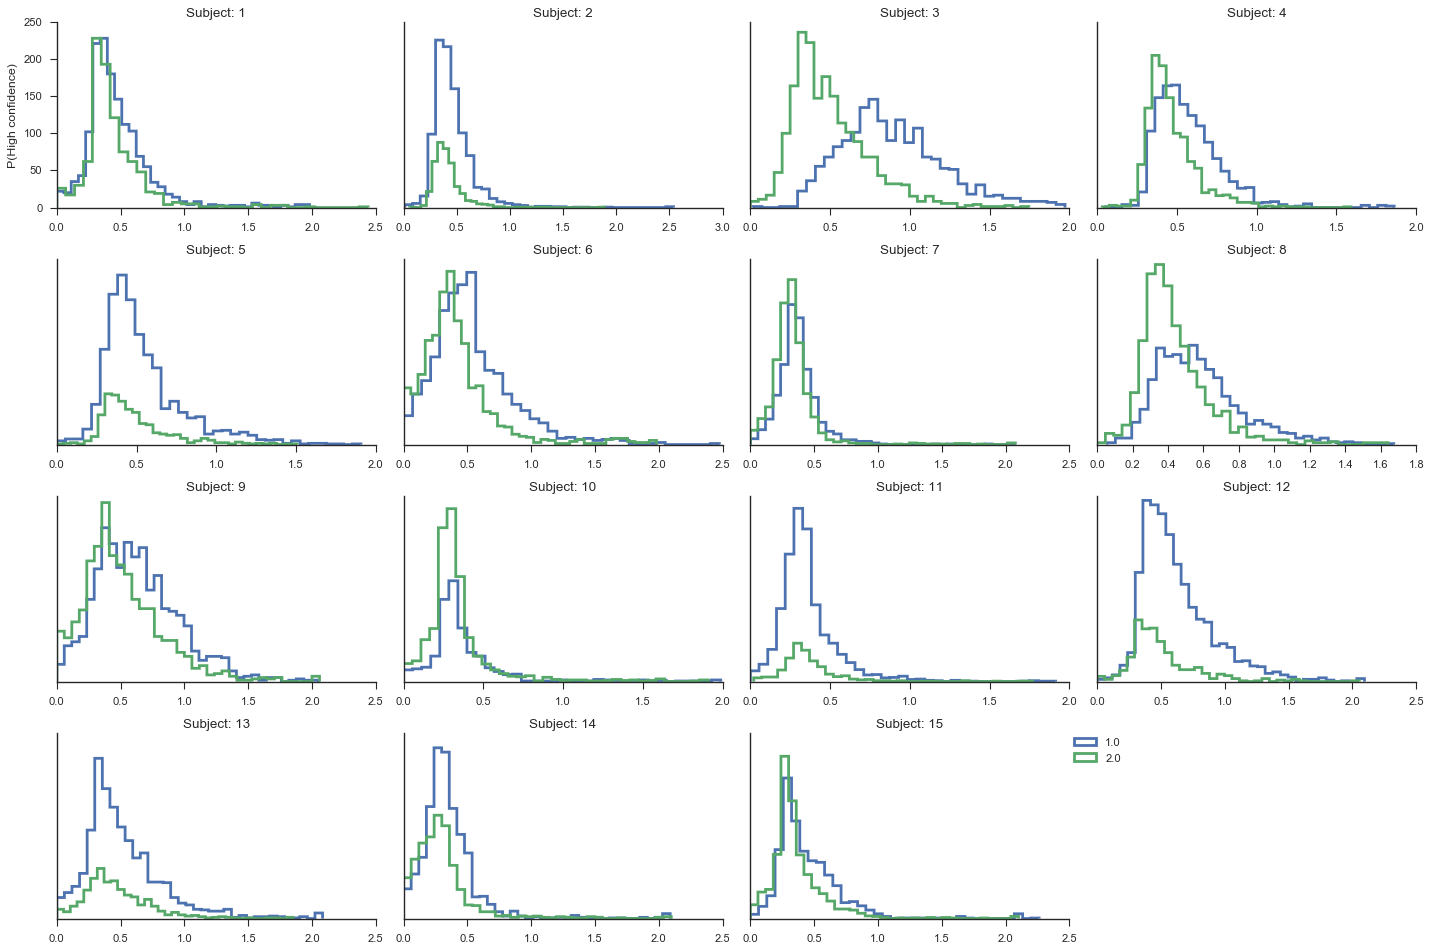

In [70]:
figure(figsize=(18, 12))
for c, sub in data.groupby('snum'):
    subplot(4,4,c)
    cnt = 0
    for d, dec in sub.groupby(['confidence']):
        rts = dec.choice_rt[~isnan(dec.choice_rt)]
    
        hist(rts.values, 35, histtype='step', label=str(d), lw=2.5)
    if c>1:
        yticks([])
    if c==1:
        ylabel('P(High confidence)')

    title('Subject: %i'%c)
sns.despine()
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()


In [72]:
log(0)

-inf

In [264]:
bins

[array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ])]

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(-0.2, 1.0)


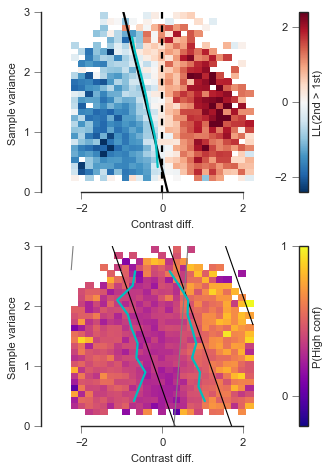

In [130]:
import matplotlib.pyplot as plt
import patsy
plt.rcParams['svg.fonttype'] = 'none'
fig = figure(figsize=(4.5, 6))
bins = [linspace(0, 3.,31), linspace(-3,3,31)]
gray()
stddf = []

subplot(2,1,1)
log_res, results = empirical.fit_logistic(dz, 'R ~ mc + stdc', summary=False)
_ = empirical.plot_model(dz, results, bins=surface_bins, cmap='RdBu_r')
ax = gca()
for j, sub in dz.groupby('snum'):
    log_res, results = empirical.fit_logistic(sub, 'R ~ mc + stdc', summary=False)
    stddf.append({'beta':results.params['stdc'], 
                  'snum':j, 
                  'mcb':results.params['mc']})
plt.locator_params(nbins=4)

#sns.despine()
xlabel('')
ylabel('Sample variance')

pos = ax.get_position()

left, bottom, width, height = pos.bounds
bottom = bottom+0.05
height = height*0.9
left = left+width+0.1
width = width/15
#cxa = fig.add_axes([left, bottom, width, height])
colorbar(label='LL(2nd > 1st)', ticks=[-2, 0, 2])
xlabel('Contrast diff.')
xlim([-3, 3])

iso_choice_contour = get_iso_contour(dz, side=-1, nbins=10, which='choice').groupby('STD').mean().reset_index()
plot(iso_choice_contour['Mean contrast point'].values, iso_choice_contour.STD.values, color='c', lw=2)

subplot(2,1,2)
dz.loc[:, 'conf0_index'] = dz.loc[:, 'confidence']-1
confidence_borders(dz)
conf_surface(dz, surface_bins, cmap='plasma', 
             vmin=-0.2, vmax=1., mincnt=5)
for im in gca().get_images():
    print im.get_clim(0, 0.05)
ax = gca()
xlabel('Contrast diff.')

ylabel('Sample variance')
xlim([-3, 3])
plt.locator_params(nbins=4)

left, bottom, width, height = ax.get_position().bounds
bottom = bottom+0.0075
height = height*0.9
left = left+width+0.1
width = width/15

iso_conf_contour = get_iso_contour(dz, side=1, nbins=10).groupby('STD').mean().reset_index()
plot(iso_conf_contour['Mean contrast point'].values, iso_conf_contour.STD.values, color='c', lw=2)

iso_conf_contour = get_iso_contour(dz, side=-1, nbins=10).groupby('STD').mean().reset_index()
plot(iso_conf_contour['Mean contrast point'].values, iso_conf_contour.STD.values, color='c', lw=2)

colorbar(label='P(High conf)', ticks=[0, 1])
ylabel('Sample variance')


sns.despine(trim=True)
tight_layout() 
savefig('/Users/nwilming/u/conf_analysis/plots/contrast_vs_std_all.svg', dpi=1200)
savefig('/Users/nwilming/u/conf_analysis/plots/contrast_vs_std_all.pdf', dpi=1200)

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(0.0, 1)
(0.0, 1)
(0.0, 1)
(0.0, 1)
(0.0, 1)


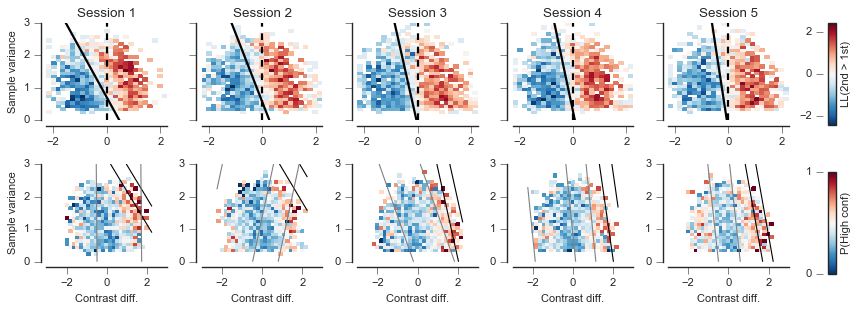

In [166]:
###HERE
fig = figure(figsize=(12, 4))

gray()
stddf = []

gs = matplotlib.gridspec.GridSpec(2, 6)
for i, ( noise, nd) in enumerate(dz.groupby('session_num')):
    subplot(gs[0, i])    
    log_res, results = empirical.fit_logistic(nd, 'R ~ mc + stdc', summary=False)
    _ = empirical.plot_model(nd, results, bins=bins, cmap='RdBu_r')
    ax = gca()
    for j, sub in nd.groupby('snum'):
        log_res, results = empirical.fit_logistic(sub, 'R ~ mc + stdc', summary=False)
        stddf.append({'session':i, 'beta':-results.params['stdc'], 
                      'snum':j, 
                      'mcb':results.params['mc']})
    plt.locator_params(nbins=4)

    #sns.despine()
    xlabel('')
    ylabel('Sample variance')
    title('Session %i'%(i+1))
    pos = ax.get_position()
    if i>0:
        ylabel('')
        yticks(yticks()[0], [])
left, bottom, width, height = pos.bounds
bottom = bottom+0.05
height = height*0.9
left = left+width+0.1
width = width/15
cxa = fig.add_axes([left, bottom, width, height])
colorbar(label='LL(2nd > 1st)', ax=ax, cax=cxa, ticks=[-2, 0, 2])


std_conf = []
for i, ( noise, nd) in enumerate(dz.groupby('session_num')):
    subplot(gs[1, i])
    ma, sa, mb, sb = confidence_borders(nd)

    conf_surface(nd, bins, cmap='RdBu_r', 
                 vmin=0., vmax=1, mincnt=5)
    
    for snum, sd in nd.groupby('snum'):
        ma, sa, mb, sb = confidence_borders(sd, plot=False)
        std_conf.append({'session':i, 'beta_ref':sa, 
              'beta_test':sb,
              'snum':snum, 
              'mcb':results.params['mc']})
    
    ax = gca()
    xlabel('Contrast diff.')
    if i == 0:
        ylabel('Sample variance')
    xlim([-3, 3])
    plt.locator_params(nbins=4)
    
left, bottom, width, height = ax.get_position().bounds
bottom = bottom+0.0075
height = height*0.9
left = left+width+0.1
width = width/15
cxa = fig.add_axes([left, bottom, width, height])
colorbar(label='P(High conf)', ax=ax, cax=cxa, ticks=[0, 1])

    

sns.despine(offset=5)
tight_layout() 
savefig('/Users/nwilming/u/conf_analysis/plots/fig4_contrast_vs_std.png')
savefig('/Users/nwilming/u/conf_analysis/plots/fig4_contrast_vs_std.pdf')

In [136]:
k = pd.DataFrame(std_conf)
k.head()

,beta_ref,beta_test,mcb,session,snum
0,-0.620104,-0.445920,2.645646,0,1
1,-0.293793,-0.438078,2.645646,0,2
2,-0.956008,0.509352,2.645646,0,3
3,-1.328229,0.653124,2.645646,0,4
4,-1.445635,1.175965,2.645646,0,5



    library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
    df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
    ezANOVA(df2, slope, wid=snum, within=.(session,type))
    
$ANOVA
        Effect DFn DFd        F            p p<.05        ges
2      session   4  56 7.654277 5.416043e-05     * 0.06066383
3         type   2  28 6.708285 4.166531e-03     * 0.19258320
4 session:type   8 112 6.003940 2.083962e-06     * 0.07564477

$`Mauchly's Test for Sphericity`
        Effect          W            p p<.05
2      session 0.17544708 0.0109072728     *
3         type 0.28088644 0.0002602855     *
4 session:type 0.04822857 0.5774397329      

$`Sphericity Corrections`
        Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF]
2      session 0.5891670 0.0011382888         * 0.7160756 4.408105e-04
3         type 0.5816951 0.0163326236         * 0.6018277 1.528392e-02
4 session:type 0.5476856 0.0002567778         * 0.828120

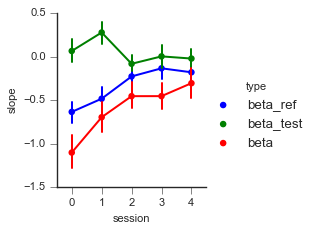

In [176]:
df_conf_slope = pd.DataFrame(std_conf)
df_slope = pd.DataFrame(stddf)
cfslopes = df_conf_slope.drop('mcb', axis=1).set_index(['session', 'snum']).stack()
chslopes = df_slope.drop('mcb', axis=1).set_index(['session', 'snum']).stack()
slopes = pd.concat([cfslopes, chslopes]).reset_index()
slopes.columns = ['session', 'snum', 'type', 'slope']
ranova_rm('slope', ['session', 'type'], slopes)
#figure(figsize=(3, 3))
sns.factorplot(x='session', y='slope', hue='type', data=slopes, ci=68, size=3)
sns.despine()
savefig('/Users/nwilming/u/conf_analysis/plots/decision_function_slopes_ranova.svg')
savefig('/Users/nwilming/u/conf_analysis/plots/decision_function_slopes_ranova.png')

In [183]:
'%1.5f'%2.083962e-06

'0.00000'

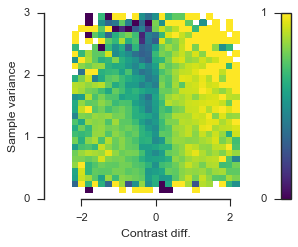

In [234]:
import matplotlib.pyplot as plt
fig = figure(figsize=(4.5, 3))
plt.rcParams['svg.fonttype'] = 'none'
bins = [linspace(0, 3.,31), linspace(-3,3,31)]
gray()

idnan = isnan(dz.correct.values)
nresp = histogram2d(dz.stdc.values[~idnan], dz.mc.values[~idnan],
        bins=surface_bins)[0]
ncorr = histogram2d(dz.stdc.values[~idnan], dz.mc.values[~idnan],
        bins=surface_bins, weights=dz.correct.values[~idnan])[0].astype(float)
pcol=plt.pcolormesh(surface_bins[1], surface_bins[0], np.ma.masked_invalid(ncorr/nresp), cmap='viridis', 
                    vmin=0, vmax=1, rasterized=True, linewidth=0)
pcol.set_edgecolor('face')
colorbar(ticks=[0,1])
xlim([-3, 3])
xlabel('Contrast diff.')

ylabel('Sample variance')
plt.locator_params(nbins=4)
sns.despine(trim=True)
savefig('/Users/nwilming/u/conf_analysis/plots/correct_surface.png')
savefig('/Users/nwilming/u/conf_analysis/plots/correct_surface.svg', dpi=1200)

In [98]:
# Do a repeated measures ANOVA in R using ezANOVA
kd = df_slope.query('session>0')
kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
kd.loc[:, 'session'] = 'C' + kd.session.astype(str)
kd.to_csv('/Users/nwilming/kernels2.csv')

print 'T-test for joint effect:'
print ttest_1samp(kd.groupby('snum').mean().beta, 0)
print kd.groupby('snum').mean().beta.mean()

print 'RM ANOVA in R:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, beta, wid=snum, within=.(session))
'''
print robjects.r(R_cmd)

T-test for joint effect:
Ttest_1sampResult(statistic=3.2379432144027893, pvalue=0.0059538083951819303)
0.477256192131
RM ANOVA in R:
$ANOVA
   Effect DFn DFd        F          p p<.05        ges
2 session   3  42 3.901574 0.01514487     * 0.04975074

$`Mauchly's Test for Sphericity`
   Effect         W         p p<.05
2 session 0.5784178 0.2244784      

$`Sphericity Corrections`
   Effect       GGe      p[GG] p[GG]<.05       HFe      p[HF] p[HF]<.05
2 session 0.7266248 0.02794561         * 0.8657019 0.02043378         *




/Users/nwilming/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
test_tmp = df_conf_slope.drop('mcb', axis=1).set_index(['snum', 'session']).stack().reset_index()
test_tmp.columns = ['snum', 'session', 'sign', 'values']

In [ ]:
ranova_rm('values', ['session', 'sign'], test_tmp)

In [ ]:
df_conf_slope.query('session==2').mean()

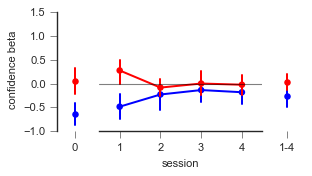

In [128]:
from scipy.stats import ttest_rel
figure(figsize=(4, 2))
gs = matplotlib.gridspec.GridSpec(1, 6)
df_conf_slope = pd.DataFrame(std_conf)

subplot(gs[0, 1:-1])
sns.pointplot(x='session', y='beta_ref', data=df_conf_slope.query('session>0'), size=3)
sns.pointplot(x='session', y='beta_test', data=df_conf_slope.query('session>0'), size=3, color='r')
ylim(-1, 1.6)
yticks([])
ylabel('')
sns.despine(left=True, ax=gca())
axhline(0, color='k', alpha=0.5)

subplot(gs[0, -1])
sns.pointplot(x='session', y='beta_ref', data=df_conf_slope.query('session>0').groupby('snum').mean(), 
              size=3, ci=95)
sns.pointplot(x='session', y='beta_test', data=df_conf_slope.query('session>0').groupby('snum').mean(), 
              size=3, ci=95, color='r')

s, i, r, p, se = linregress(
    df_conf_slope.session.values, 
    df_conf_slope.beta_ref.values)
ylim(-1, 1.6)
yticks([])
ylabel('')
xticks([0], ['1-4'])
xlabel('')
sns.despine(left=True, ax=gca(), trim=True)



subplot(gs[0, 0])
s0 = df_conf_slope.query('session==0')
sns.pointplot(x='session', y='beta_ref', data=df_conf_slope.query('session==0'), size=3)
sns.pointplot(x='session', y='beta_test', data=df_conf_slope.query('session==0'), size=3, color='r')

xlim([-1, 1])
ylim(-1, 1.6)
xlabel('')
ylabel('confidence beta')
sns.despine(ax=gca(), trim=True)

savefig('/Users/nwilming/u/conf_analysis/plots/conf_betas.png')

### Analyze timing


In [ ]:
metas = pd.read_hdf('/Users/nwilming/u/conf_analysis/metas.hdf')

In [ ]:
metas.columns

In [ ]:
metas.set_index('session_num', append=True, inplace=True)

In [ ]:
metas.set_index('snum', append=True, inplace=True)

In [ ]:
(54820-50437)/1200.

In [ ]:
for snum, smeta in metas.groupby(level='snum'):
    itis = []
    for i, d in smeta.groupby(level=['snum', 'session_num', 'block_num']):
        ITIs = (d.ref_onset_t.values[1:] - d.meg_feedback_t.values[:-1])/1200.
        itis.append(ITIs)
    #print d.reset_index().loc[:, ('ref_onset_t', 'end', 'meg_feedback_t')]
    itis = concatenate(itis)
    itis = itis[~isnan(itis)]
    print snum, mean(itis)

In [ ]:
subplot(1,2,1)
ref_stim_delay = diff(metas.loc[:, ['ref_offset_t', 'stim_onset_t']])/1200.
hist(ref_stim_delay, 31)
print 'Ref -> Stim:', min(ref_stim_delay), mean(ref_stim_delay), max(ref_stim_delay)
subplot(1,2,2)
resp_feed_delay = diff(metas.loc[:, ['button_t', 'meg_feedback_t']])/1200.
resp_feed_delay = resp_feed_delay.ravel() #+metas.choice_rt.values
resp_feed_delay = resp_feed_delay[~isnan(resp_feed_delay)]
a,b = histogram(resp_feed_delay, linspace(0, 2, 51))

k = cumsum(a)/float(sum(a))
c = b[:-1] + diff(b)[0]
print c[argmin(abs(k-.2))]
plot(c, k)

print 'Response -> Feedback:', min(resp_feed_delay), mean(resp_feed_delay), max(resp_feed_delay)



sns.despine()